**This notebook walks through iterative modeling. Nine different variations of data were tried across mostly untuned Decision Trees and Random Forest classifiers. Tried a KNN with the dataset that got the best results from these (DV7) and tried KNN model - but metrics did not compare. Stick with Random Forest and tune in notebook 92_**

Business problem: Customers get Peloton bike delivered and ask, what class should I take first?

Difficulty will be basis of how they choose - build model to predict difficulty based on class daya including roll up stats of playlist.

- False Positive - a class is labeled easy, but it isn't
- False Negative - a class is not labeled easy, but it is

**Both are equally important to account for - use F1 Score**

Note: A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, **micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).**
Source: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [1]:
# Basics 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Importing dfs with heavy processing
import pickle

# Imports Modeling
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, plot_confusion_matrix

# Feat Imp
from yellowbrick.model_selection import FeatureImportances

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# Just in case other pickle files available
# # Opening pickle files
# # Use classId where you can as key for merging
# base_clean_df = pd.read_pickle("./base_clean_df.pkl")
# artist_df = pd.read_pickle("./artist_df.pkl")
# artist_id_class_count = pd.read_pickle("larger_spot_artist_id_class_count.pkl")  # has artist features
# songs_df = pd.read_pickle("./songs_df.pkl")
# song_class_count_df = pd.read_pickle("./song_class_count_df.pkl")
# song_class_count_df.rename(columns={'Artist':'Song'}, inplace=True) # Quick clean rename column
# class_type_reorg_df = pd.read_pickle("./class_type_reorg_df.pkl")
# new_class_types_with_artists = pd.read_pickle("./new_class_types_with_artists.pkl")
# master_song_df = pd.read_pickle("./master_song_df.pkl") # has song features
# # artist_id_class_count has 186 rows with 0LyfQWJT6nXafLPZqxe9Of - it means Various Artists
# # and 40 errors

In [3]:
df = pd.read_pickle("./master_first_classes_with_stats.pkl")
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0,3.611225,Music
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0,5.703883,Intervals
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5,3.729600,Beginner
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0,3.624000,Music
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0,3.800000,Music


In [4]:
df['classDifficulty'].describe()

count    6983.000000
mean        7.858991
std         0.778619
min         4.272800
25%         7.554450
50%         8.047400
75%         8.378250
max         9.653600
Name: classDifficulty, dtype: float64

In [5]:
def label_class_diff_cat(classDifficulty):
    if classDifficulty < 7.55:
        return 'Beginner'
    if classDifficulty >= 7.55 and classDifficulty < 8.37:
        return 'Intermediate'
    if classDifficulty >= 8.37:
        return 'Advanced'

In [6]:
# Create classDifficulty_cat for categories of Class Difficulty for classification target
df['classDifficulty_cat'] = df['classDifficulty'].apply(label_class_diff_cat)

## Modeling

### First Shitty Model - Using Class Name

In [7]:
# Define X and y 

# Drop unique Id/URL, target/associated difficulty columns, date/ratings not being used, length is correlated with class_Duration
# Equipment is all bike, Songs/Artists in Spotify roll up stats
# doing first model with className and not classCategory since that was feature eng'ed
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'classCategory'])

#y is the target created previously
y = df['classDifficulty_cat']

In [8]:
# Review X columns for treatment assignment
X.columns

Index(['className', 'classDuration', 'classLocation', 'instructorName', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins'], dtype='object')

In [9]:
# Separate for different treatments (scaling and OHE)

num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['className','classLocation', 'instructorName']

#### Numeric Treatment - Scale

In [10]:
# Copy df for manipulation
scaled_features = df.copy()

In [11]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [12]:
# Copy df for manipulation
ohe_features = df.copy()

In [13]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,className_10 min Climb Ride,className_10 min Low Impact Ride,className_10 min Tabata Ride,className_15 Hip Hop Ride,className_15 min 2000s Hip Hop Ride,className_15 min 2000s Pop Ride,className_15 min 2000s Ride,className_15 min 2010s Ride,className_15 min 70s Ride,className_15 min 70s Rock Ride,className_15 min 80s Hip Hop Ride,className_15 min 80s Pop Ride,className_15 min 80s Ride,className_15 min 80s Rock Ride,className_15 min 90s Country Ride,className_15 min 90s Hip Hop Ride,className_15 min 90s Ride,className_15 min 90s Rock Ride,className_15 min Boss Ride,className_15 min Classic Rock Ride,className_15 min Climb Ride,className_15 min Country Ride,className_15 min EDM Ride,className_15 min EDM Trap Ride,className_15 min EDM/Electronic Dance Ride,className_15 min Feel Good Ride,className_15 min Funk Ride,className_15 min Groove Ride,className_15 min HIIT Ride,className_15 min Hip Hop Ride,className_15 min Latin Ride,className_15 min Low Impact Ride,className_15 min Metal Ride,className_15 min Motown Ride,className_15 min Move for More: Climb Ride,className_15 min Move for More: HIIT Ride,className_15 min Move for More: Tabata Ride,className_15 min New Tracks Ride,className_15 min New Wave Ride,className_15 min Pick-Me-Up Ride,className_15 min Pop Ride,className_15 min R&B Ride,className_15 min Rock Ride,className_15 min Soul Music Ride,className_15 min Soul Ride,className_15 min Southern Rock Ride,className_15 min Tabata Ride,className_20 HIIT Ride,className_20 House Ride,className_20 min 2000s Hip Hop Ride,className_20 min 2000s Pop Ride,className_20 min 2000s Ride,className_20 min 2010s Hip Hop Ride,className_20 min 2010s Pop Ride,className_20 min 2010s Ride,className_20 min 50s Rock Ride,className_20 min 60s Pop Ride,className_20 min 60s Ride,className_20 min 70s Pop Ride,className_20 min 70s Ride,className_20 min 70s Rock Ride,className_20 min 80s Hip Hop Ride,className_20 min 80s Pop Ride,className_20 min 80s Ride,className_20 min 80s Rock Ride,className_20 min 90s Country Ride,className_20 min 90s Dance Ride,className_20 min 90s Hip Hop Ride,className_20 min 90s Pop Ride,className_20 min 90s Ride,className_20 min 90s Rock Ride,className_20 min AHM Celebration Ride,className_20 min AHM: Pop Ride,className_20 min Afrobeats Ride,className_20 min BHM Celebration Ride,className_20 min BHM: 80s Hip Hop Ride,className_20 min BHM: Black on Broadway Ride,className_20 min BHM: Broadway Ride,className_20 min BHM: Hip Hop Ride,className_20 min BHM: Jazz Ride,className_20 min BHM: Listening Party,className_20 min BHM: Rock Ride,className_20 min Beginner Ride,className_20 min Best of 2020 Ride,className_20 min Best of the Decade Ride,className_20 min Blues Ride,className_20 min Boss Ride,className_20 min British Pop Ride,className_20 min British Rock Ride,className_20 min Broadway Ride,className_20 min Caribbean Holiday Ride,className_20 min Caribbean Music Ride,className_20 min Classic Rock Ride,className_20 min Classical Music Ride,className_20 min Climb Ride,className_20 min Country Ride,className_20 min Disco Ride,className_20 min EDM Ride,className_20 min EDM Ride: From Home,className_20 min EDM Trap Ride,className_20 min EDM/Electronic Dance Ride,className_20 min Electronic Dance/EDM Ride,className_20 min Feel Good Ride,className_20 min Funk Ride,className_20 min Go Canada! Ride,className_20 min Groove Ride,className_20 min HIIT Ride,className_20 min Hip Hop Ride,className_20 min Holiday Ride,className_20 min House Ride,className_20 min Intervals Ride,className_20 min Jam Band Ride,className_20 min King Princess Ride,className_20 min LHM Celebration Ride,className_20 min LHM: Fresh Friday Ride,className_20 min Latin Celebration Ride,className_20 min Latin Ride,className_20 min Listening Party,className_20 min Low Impact Ride,className_20 min Metal Ride,className_20 min Ministry of Sound: The Chill Out,className_20 min New Tracks Ride,className_20 min New Wave Ride,className_20 min Peloton All-Star Ride,className_20 min Pi

In [14]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine - Data Version 1 - Many OHE, First Shitty Model

In [15]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [16]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       ...
       'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Mayla Wedekind', 'instructorName_Olivia Amato', 'instructorName_Robin Arzón', 'instructorName_Sam Yo', 'instructorName_Tunde Oyeneyin', 'classDifficulty_cat'], dtype='object', length=599)

In [17]:
model_results = pd.DataFrame(columns=['data_version', 'estimator', 'train_acc', 'train_f1',
                                     'test_acc', 'test_f1', 'test_f1_cross'])

In [18]:
model_results

,data_version,estimator,train_acc,train_f1,test_acc,test_f1,test_f1_cross


In [19]:
scores_list = [1, 2, 3, 4, 5, 6, 7]

In [20]:
# REVISIT THIS TO GET MODEL RESULTS IN A DF

# def calc_scores(estimator, X_train, X_test, y_train, y_test, data_version, target_names, average):
#     # grab predictions
#     train_preds = estimator.predict(X_train)
#     test_preds = estimator.predict(X_test)
    
#     # Scores in df row
#     data_v = data_version
#     train_acc = accuracy_score(y_train, train_preds)
#     train_f1 = f1_score(y_train, train_preds, average=average)
#     test_acc = accuracy_score(y_test, test_preds)
#     test_f1 = f1_score(y_test, test_preds, average=average)
#     test_f1_cross = np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring=(f'f1_{average}')))
#     scores_list = [data_v, train_acc, train_f1, test_acc, test_f1, test_f1_cross]
#     scores_df_row = pd.DataFrame(scores_list, index =['data_version', 'estimator', 'train_acc',
#                                                       'train_f1','test_acc', 'test_f1', 'test_f1_cross']).T
#     return scores_df_row

In [21]:
def eval_model(estimator, X_train, X_test, y_train, y_test, target_names, average):
    '''
    Evaluation function to show accuracy, f1 score, mean 3-fold cross-validation 
    for both the train and test set, then shows confusion matrix for the test set
    '''   
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print report
    print(classification_report(y_test, test_preds, target_names=target_names))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds, average=average)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds, average=average)}")
    print(f"F1 Score Mean Cross Val 3-Fold: {np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring=(f'f1_{average}')))}")
    
#     # append to df
#     new_row = calc_scores(data_version, estimator, X_train, X_test, y_train, y_test, target_names, average)
#     new_row_df = pd.DataFrame(new_row)
#     frames = [model_results,new_row_df]
#     model_results = pd.concat(frames)
#     model_results.head()
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format='')
    plt.show()

#### Model 1 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [22]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
# Instantiate
dt = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.66      0.67      0.67       459
    Beginner       0.78      0.74      0.76       426
Intermediate       0.71      0.72      0.72       861

    accuracy                           0.71      1746
   macro avg       0.72      0.71      0.71      1746
weighted avg       0.71      0.71      0.71      1746

Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
--------------------
Test Scores
-----------
Accuracy: 0.7130584192439863
F1 Score: 0.7139156862670119
F1 Score Mean Cross Val 3-Fold: 0.6967730000895497


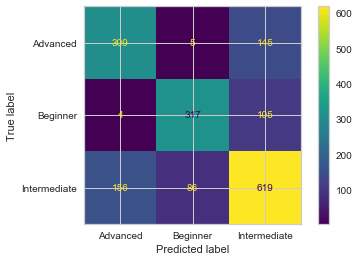

In [25]:
# Try macro, slightly worse than micro
eval_model(dt, X_train, X_test, y_train, y_test, 
           target_names=['Advanced', 'Beginner', 'Intermediate'], average='macro')

In [26]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

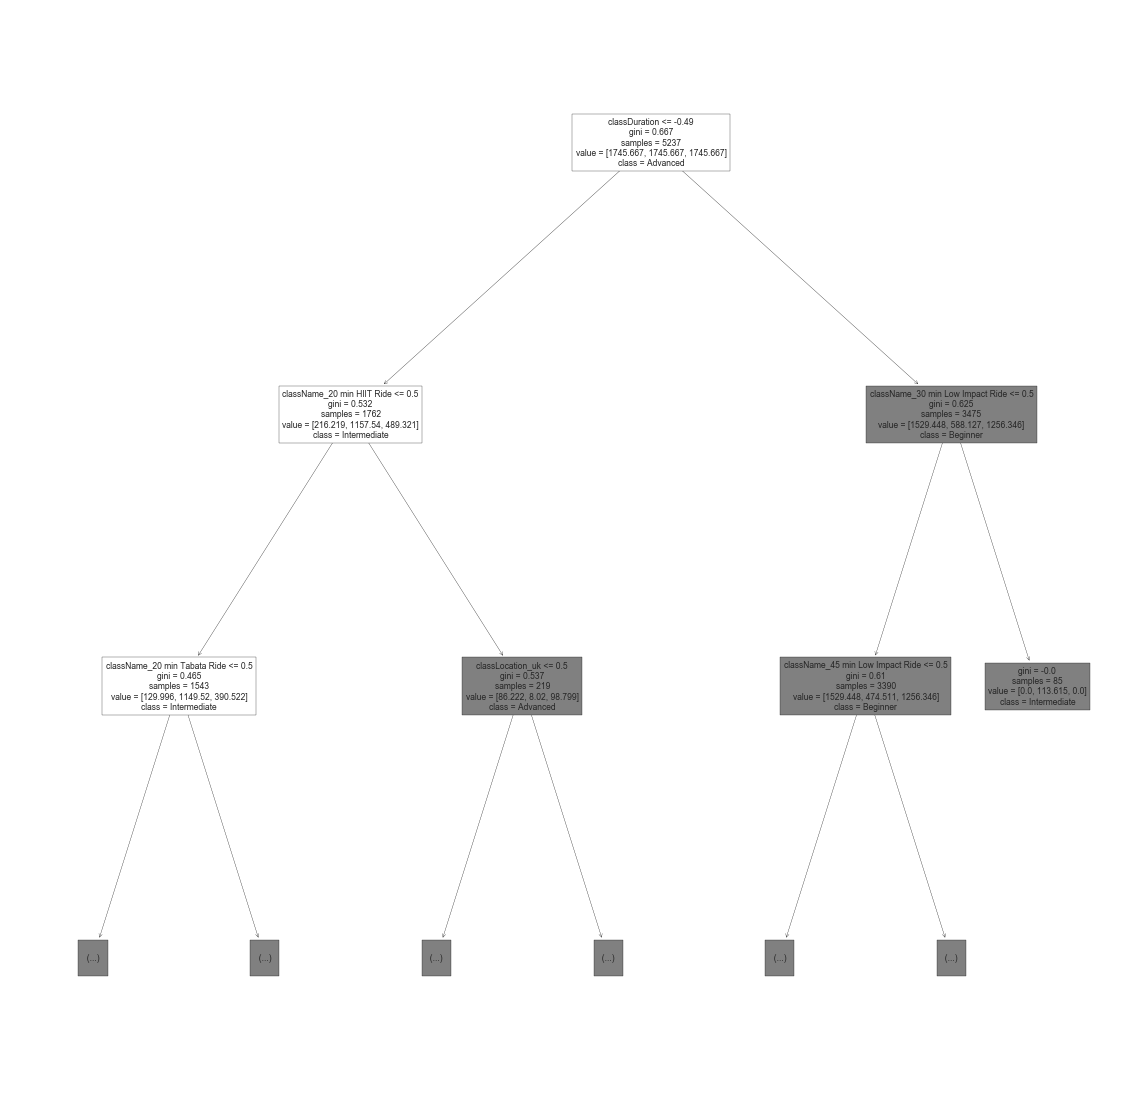

In [27]:
plt.figure(figsize=(20,20))
plot_tree(dt, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


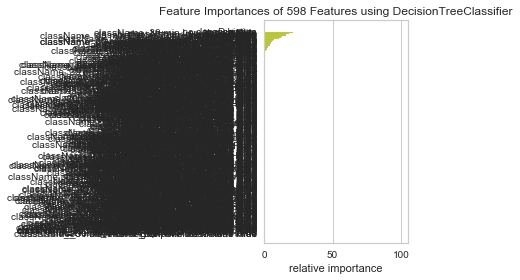

In [28]:
viz = FeatureImportances(dt, topn=3)
viz.fit(X, y)
viz.show()

#### Build Pipeline version of above

In [29]:
# # Define X and y 

# # Drop unique Id/URL, target/associated difficult columns, date/ratings not being used, length is correlated with class_Duration
# # Equipment is all bike, Songs/Artists in Spotify roll up stats
# # doing first model with className and not classCategory since that was feature eng'ed
# X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
#                      'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
#                      'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
#                     'classCategory'])

# #y is the target created previously
# y = df['classDifficulty_cat']

In [30]:
# # Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
# # Set up how to treat our columns
# num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
#             'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
#             'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

# ohe_cols = ['className','classLocation', 'instructorName']

In [32]:
# # Now, set up the preprocessing steps for each type of col
# num_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())])

# ohe_transformer = Pipeline(steps=[
#     ('ohe', OneHotEncoder(handle_unknown = 'ignore'))])

In [33]:
# # Put together our preprocessor using a Column Transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, num_cols),
#         ('ohe', ohe_transformer, ohe_cols)])

In [34]:
# # Append classifier to preprocessing pipeline.
# # Now we have a full prediction pipeline.
# clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
#                          ('classifier', DecisionTreeClassifier(class_weight='balanced'))])

# clf_dt.fit(X_train, y_train)

In [35]:
# eval_model(clf_dt, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [36]:
# # Pull classifier out from pipeline
# clf_dt.steps[1][1]

In [37]:
# # Plot decision tree
# plt.figure(figsize=(20,20))
# plot_tree(clf_dt.steps[1][1], max_depth=2, feature_names=fn, class_names=cn)
# plt.show()

#### Try Random Forest

In [38]:
# clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
#                          ('classifier', RandomForestClassifier(class_weight='balanced'))])

# clf_rf.fit(X_train, y_train)

# eval_model(clf_rf, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

### Data V2 (Class Category instead of Names)

In [39]:
# Define X and y 

# drop className and use feat. eng'ed classCategory
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [40]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory','classLocation', 'instructorName']

#### Numeric Treatment - Scale

In [41]:
# Copy df for manipulation
scaled_features = df.copy()

In [42]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [43]:
# Copy df for manipulation
ohe_features = df.copy()

In [44]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Groove,classCategory_Heart Rate Zone,classCategory_Intervals,classCategory_Live DJ,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Pro Cyclist,classCategory_Theme,classLocation_event-01,classLocation_nyc,classLocation_psny-studio-1,classLocation_uk,classLocation_uk-bike-remote-broadcast,classLocation_us-bike-remote-broadcast,instructorName_Alex & Tunde,instructorName_Alex Toussaint,instructorName_Ally & Emma,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christian Vande Velde,instructorName_Christine D'Ercole,instructorName_Cliff Dwenger,instructorName_Cody Rigsby,instructorName_Cycling Instructors 2019,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Erik Jäger,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Irène Scholz,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Mayla Wedekind,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine - Data Version 2 - classCategory instead of names, less OHE

In [46]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [47]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Groove', 'classCategory_Heart Rate Zone', 'classCategory_Intervals', 'classCategory_Live DJ', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Pro Cyclist', 'classCategory_Theme', 'classLocation_event-01', 'classLocation_nyc', 'classLocation_psny-studio-1', 'classLocation_uk', 'classLocation_uk-bike-remote-broadcast', 'classLocation_us-bike-remote-broadcast', 'instructorName_Alex & Tunde', 'instructorName_Alex Toussaint', 'instructorName_Ally & Emma', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christian Vande Velde', 'instructorName_Christine D'Ercole', 'instructorName_Cliff Dwenger',
       'i

#### Model 3 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [48]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [49]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [50]:
# Instantiate
dt2 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.65      0.64      0.64       459
    Beginner       0.70      0.72      0.71       426
Intermediate       0.69      0.69      0.69       861

    accuracy                           0.68      1746
   macro avg       0.68      0.68      0.68      1746
weighted avg       0.68      0.68      0.68      1746

Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
--------------------
Test Scores
-----------
Accuracy: 0.6821305841924399
F1 Score: 0.6821305841924399
F1 Score Mean Cross Val 3-Fold: 0.6725229231831307


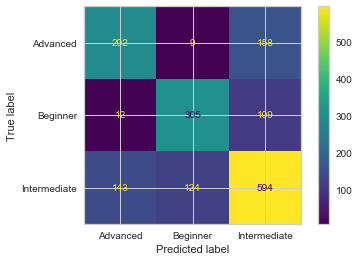

In [51]:
# Try micro 
eval_model(dt2, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [52]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

In [53]:
df[(df['classCategory'] == 'Low Impact')]['classDifficulty_cat'].value_counts()

Beginner        552
Intermediate      4
Name: classDifficulty_cat, dtype: int64

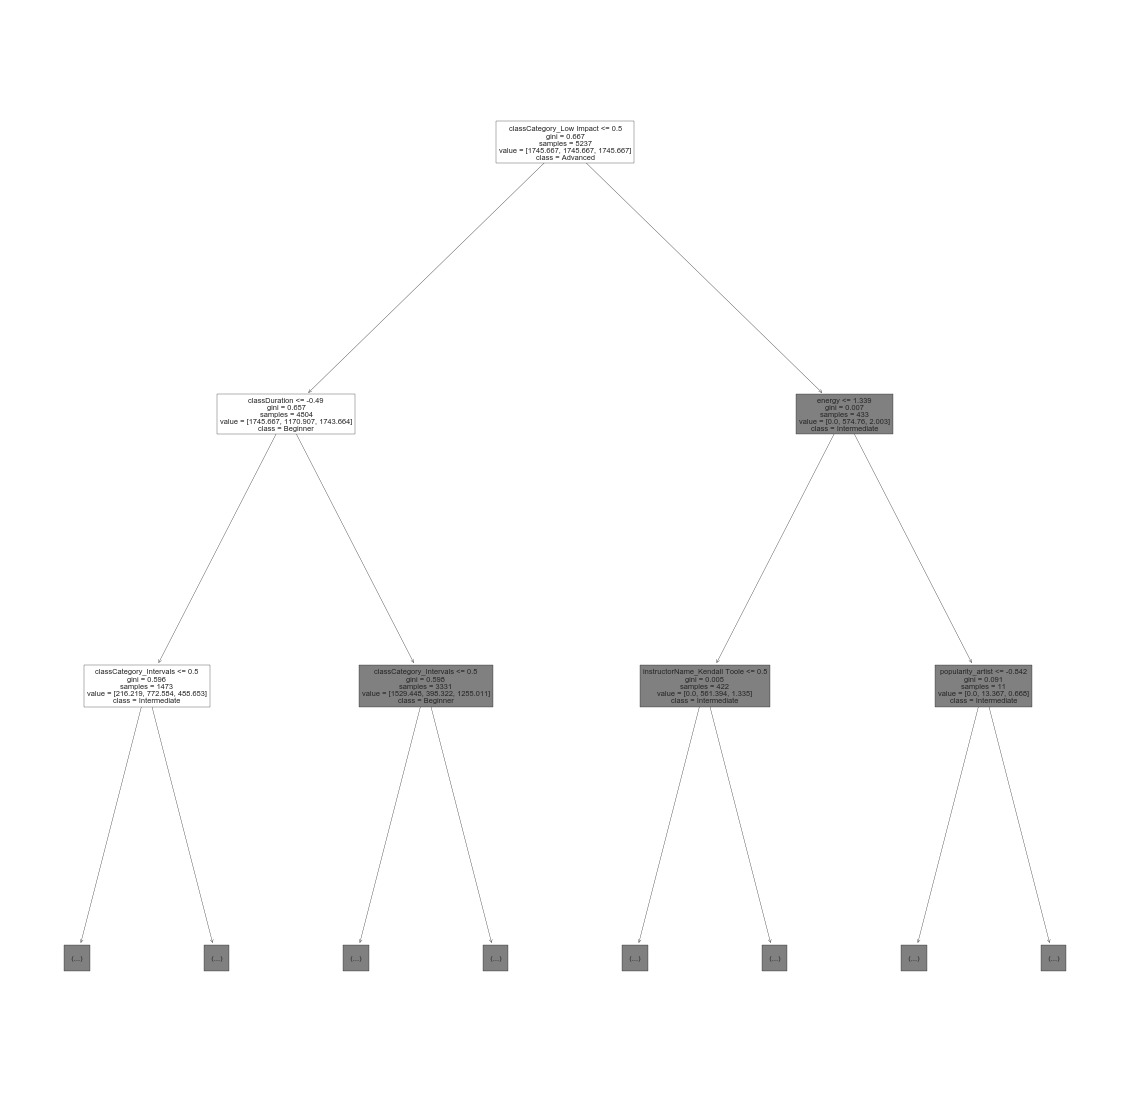

In [54]:
plt.figure(figsize=(20,20))
plot_tree(dt2, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


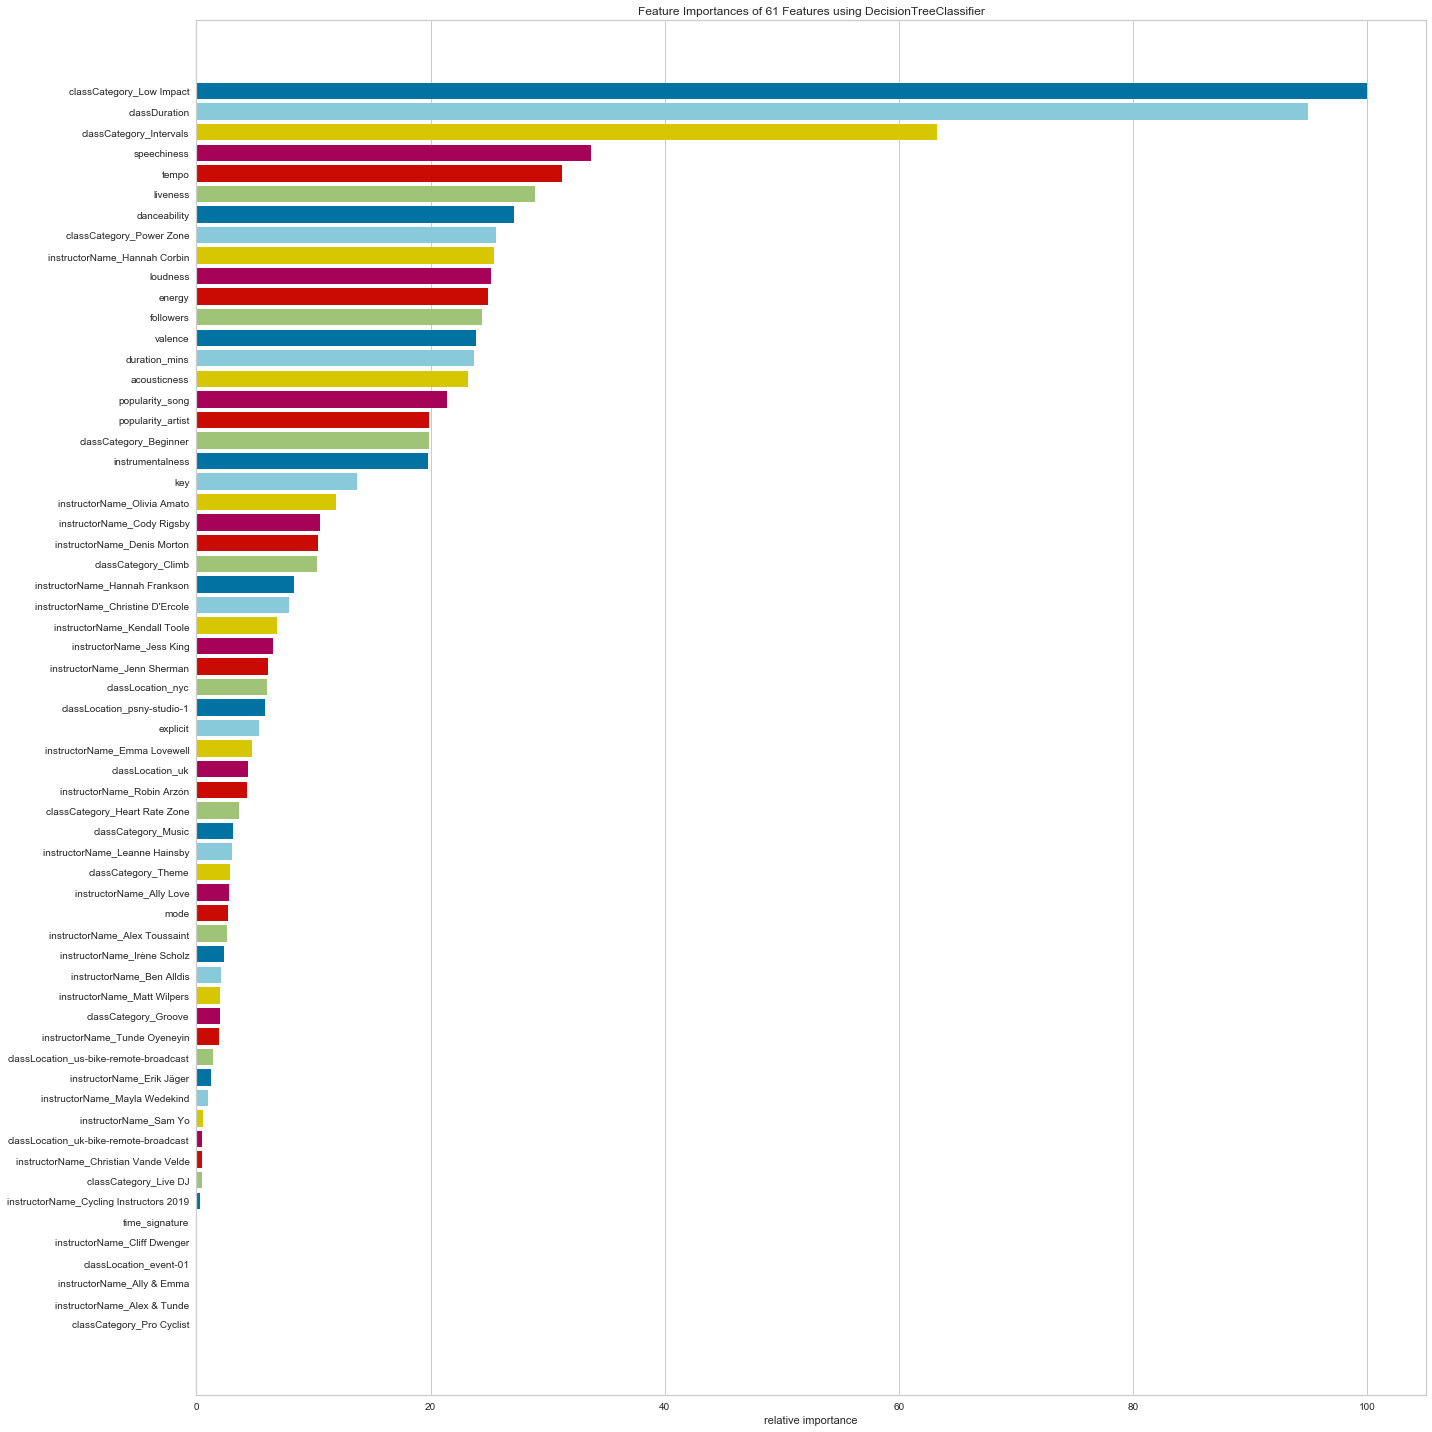

In [55]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt2)
viz.fit(X, y)
viz.show()

#### Model 4 - RF with Balanced Class Weight 

Class weight = 'balanced' to account for 25-50-25 split of Target

In [56]:
# Instantiate
rf2 = RandomForestClassifier(class_weight='balanced')

# Fit
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Advanced       0.82      0.58      0.68       459
    Beginner       0.82      0.68      0.75       426
Intermediate       0.70      0.87      0.77       861

    accuracy                           0.75      1746
   macro avg       0.78      0.71      0.73      1746
weighted avg       0.76      0.75      0.74      1746

Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
--------------------
Test Scores
-----------
Accuracy: 0.7457044673539519
F1 Score: 0.7457044673539519
F1 Score Mean Cross Val 3-Fold: 0.7324784389150915


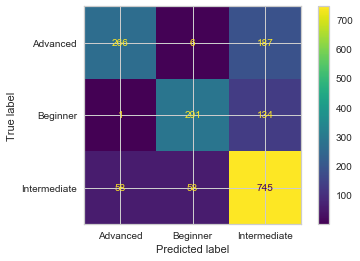

In [57]:
# Try micro 
eval_model(rf2, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


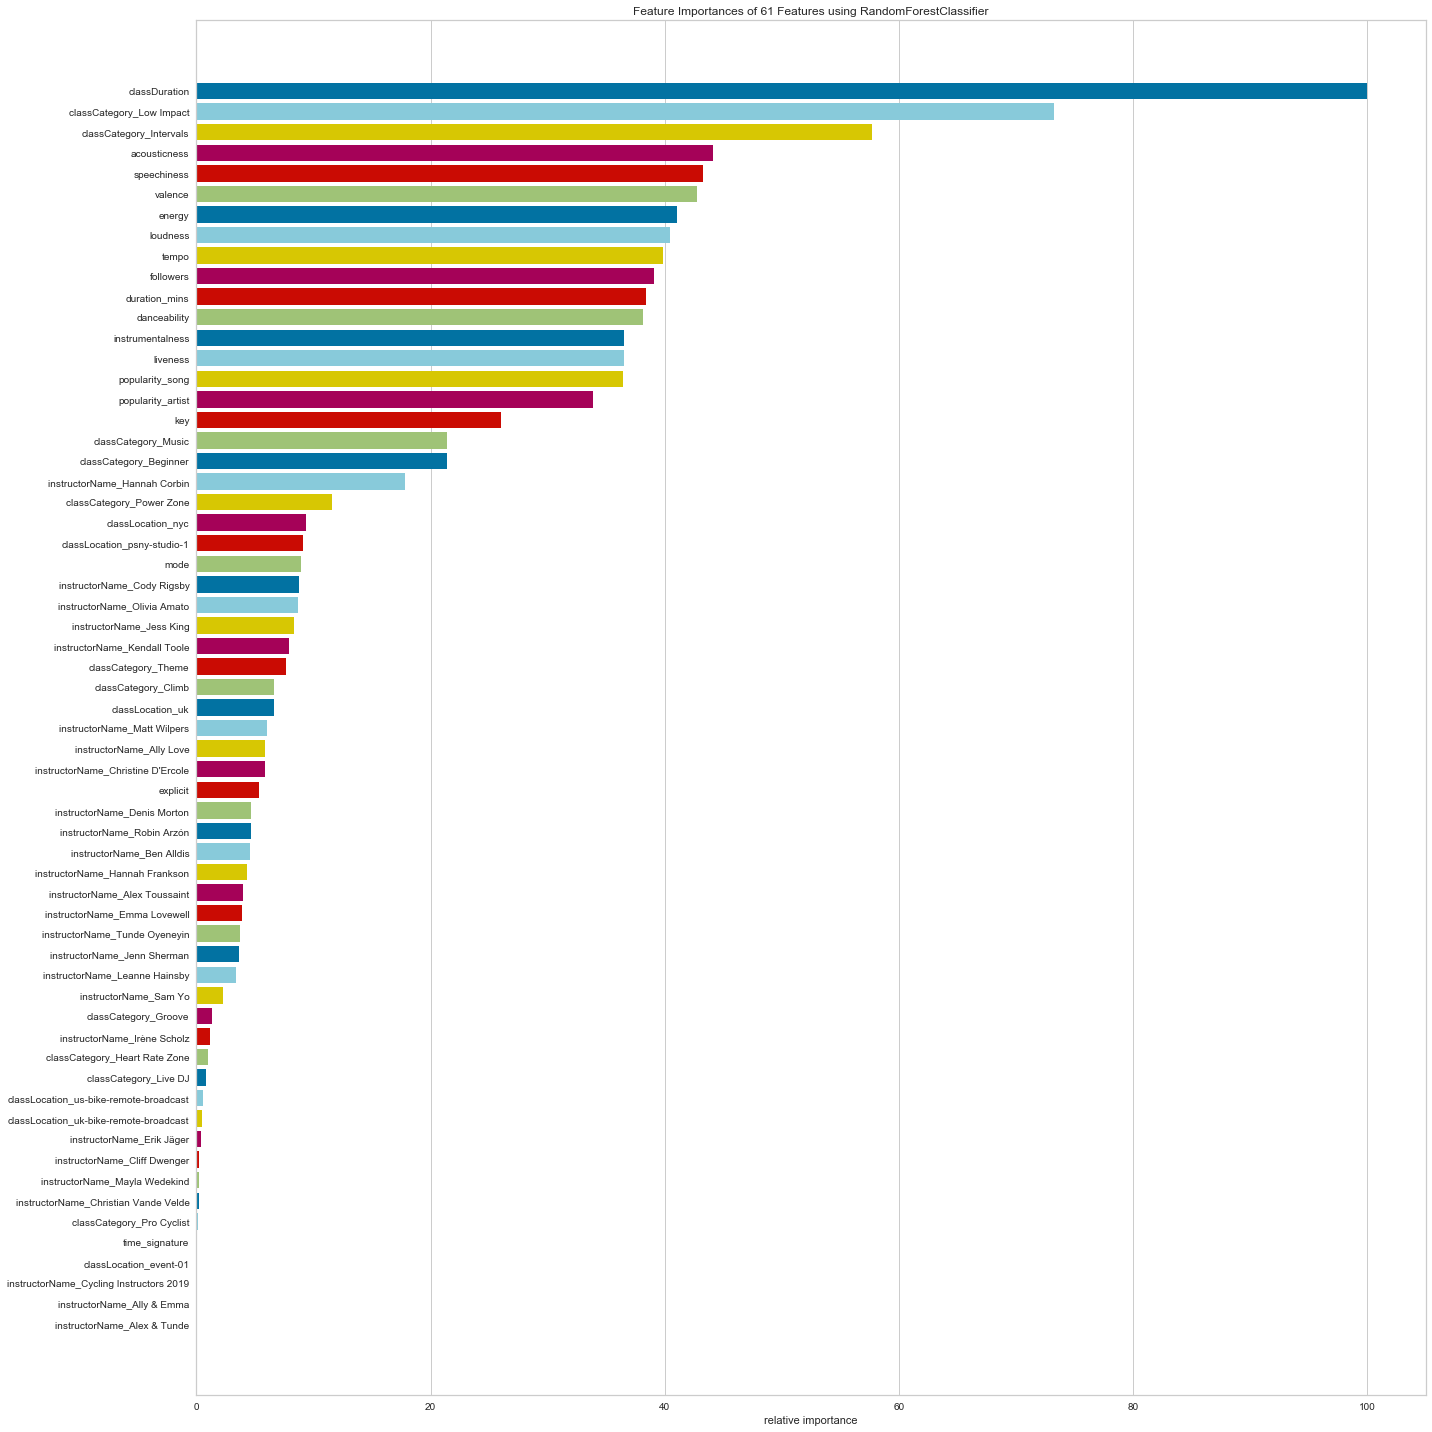

In [58]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf2)
viz.fit(X, y)
viz.show()

### Data V3 (No classLocation)

In [59]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [60]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [61]:
# Copy df for manipulation
scaled_features = df.copy()

In [62]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [63]:
# Copy df for manipulation
ohe_features = df.copy()

In [64]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Groove,classCategory_Heart Rate Zone,classCategory_Intervals,classCategory_Live DJ,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Pro Cyclist,classCategory_Theme,instructorName_Alex & Tunde,instructorName_Alex Toussaint,instructorName_Ally & Emma,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christian Vande Velde,instructorName_Christine D'Ercole,instructorName_Cliff Dwenger,instructorName_Cody Rigsby,instructorName_Cycling Instructors 2019,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Erik Jäger,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Irène Scholz,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Mayla Wedekind,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine - Data Version 3 - no classLocation, less OHE

In [66]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [67]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Groove', 'classCategory_Heart Rate Zone', 'classCategory_Intervals', 'classCategory_Live DJ', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Pro Cyclist', 'classCategory_Theme', 'instructorName_Alex & Tunde', 'instructorName_Alex Toussaint', 'instructorName_Ally & Emma', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christian Vande Velde', 'instructorName_Christine D'Ercole', 'instructorName_Cliff Dwenger', 'instructorName_Cody Rigsby', 'instructorName_Cycling Instructors 2019', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Erik Jäger',
       'instructorName_Han

#### Model 5 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [68]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [69]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [70]:
# Instantiate
dt3 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.64      0.62      0.63       459
    Beginner       0.72      0.75      0.74       426
Intermediate       0.70      0.70      0.70       861

    accuracy                           0.69      1746
   macro avg       0.69      0.69      0.69      1746
weighted avg       0.69      0.69      0.69      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.6924398625429553
F1 Score: 0.6924398625429553
F1 Score Mean Cross Val 3-Fold: 0.6719506231189096


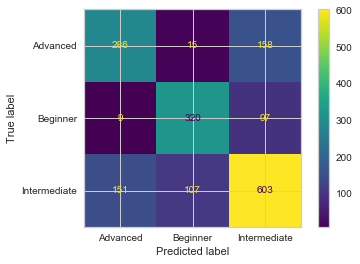

In [71]:
# Try micro 
eval_model(dt3, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [72]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

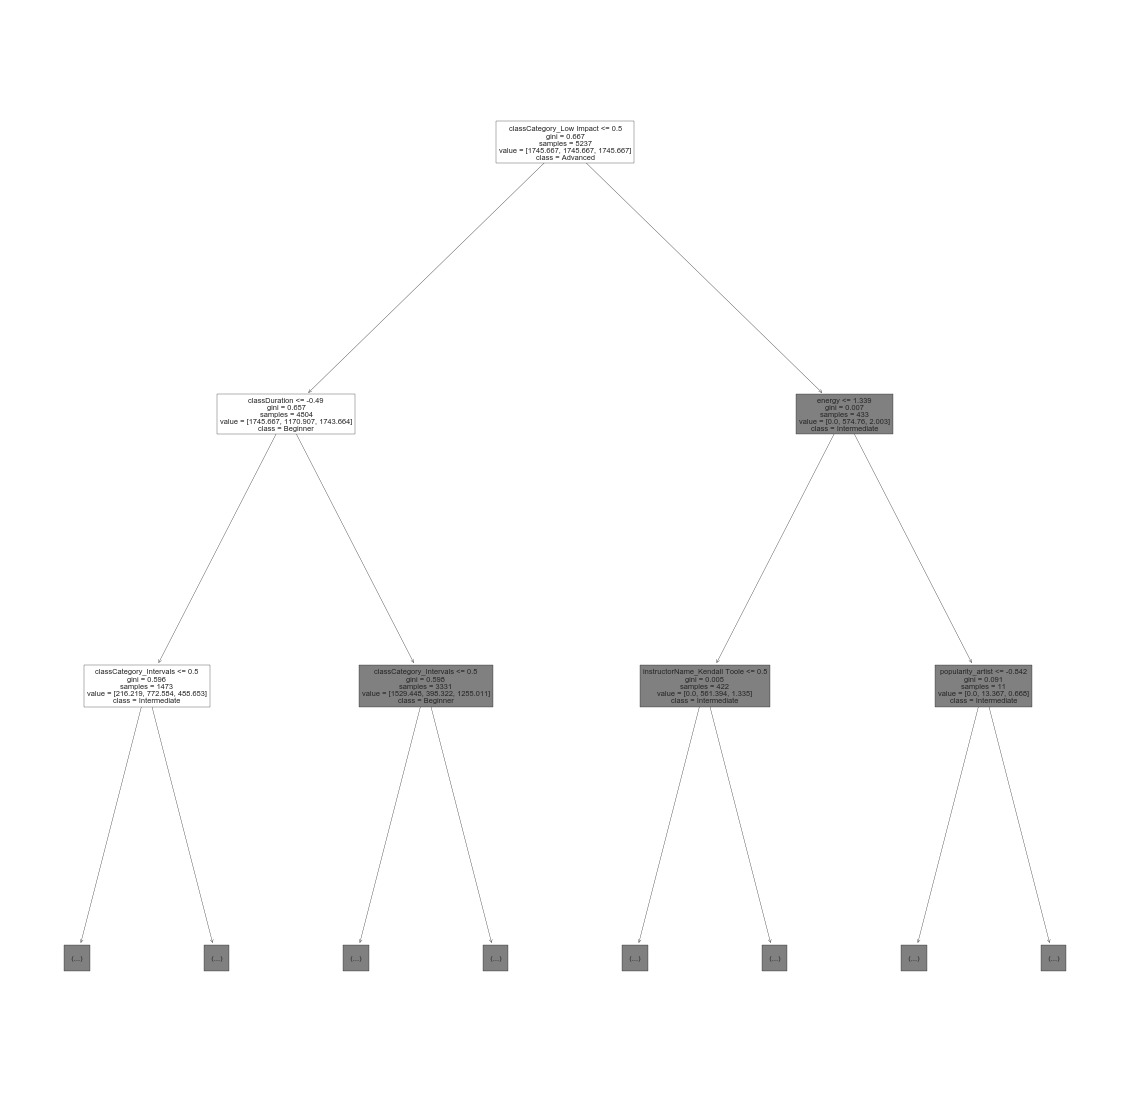

In [73]:
plt.figure(figsize=(20,20))
plot_tree(dt3, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


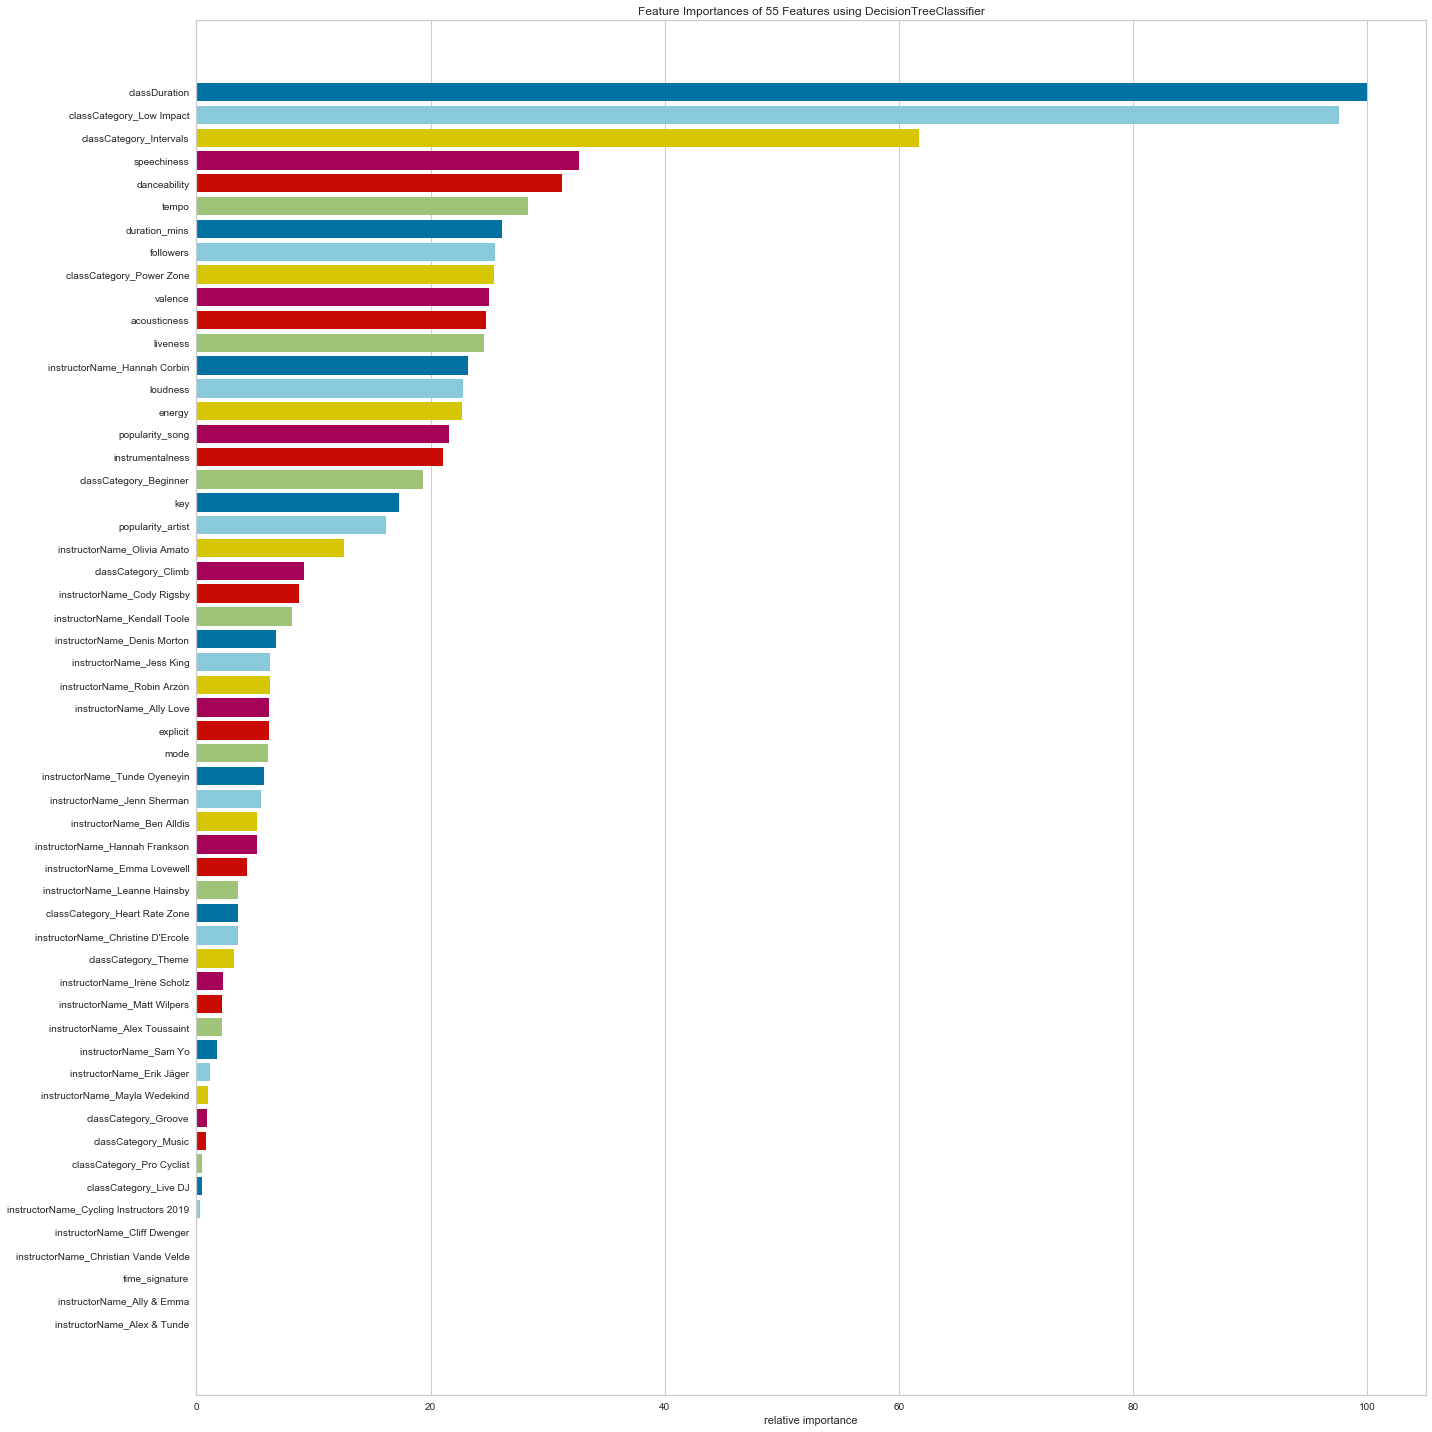

In [74]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt3)
viz.fit(X, y)
viz.show()

#### Model 6 - RF with Balanced Class Weight 

Class weight = 'balanced' to account for 25-50-25 split of Target

In [75]:
# Instantiate
rf3 = RandomForestClassifier(class_weight='balanced')

# Fit
rf3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Advanced       0.81      0.58      0.68       459
    Beginner       0.83      0.67      0.74       426
Intermediate       0.70      0.87      0.78       861

    accuracy                           0.75      1746
   macro avg       0.78      0.71      0.73      1746
weighted avg       0.76      0.75      0.74      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.7462772050400917
F1 Score: 0.7462772050400917
F1 Score Mean Cross Val 3-Fold: 0.7326701173154958


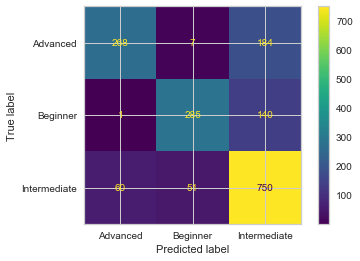

In [76]:
# Try micro 
eval_model(rf3, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


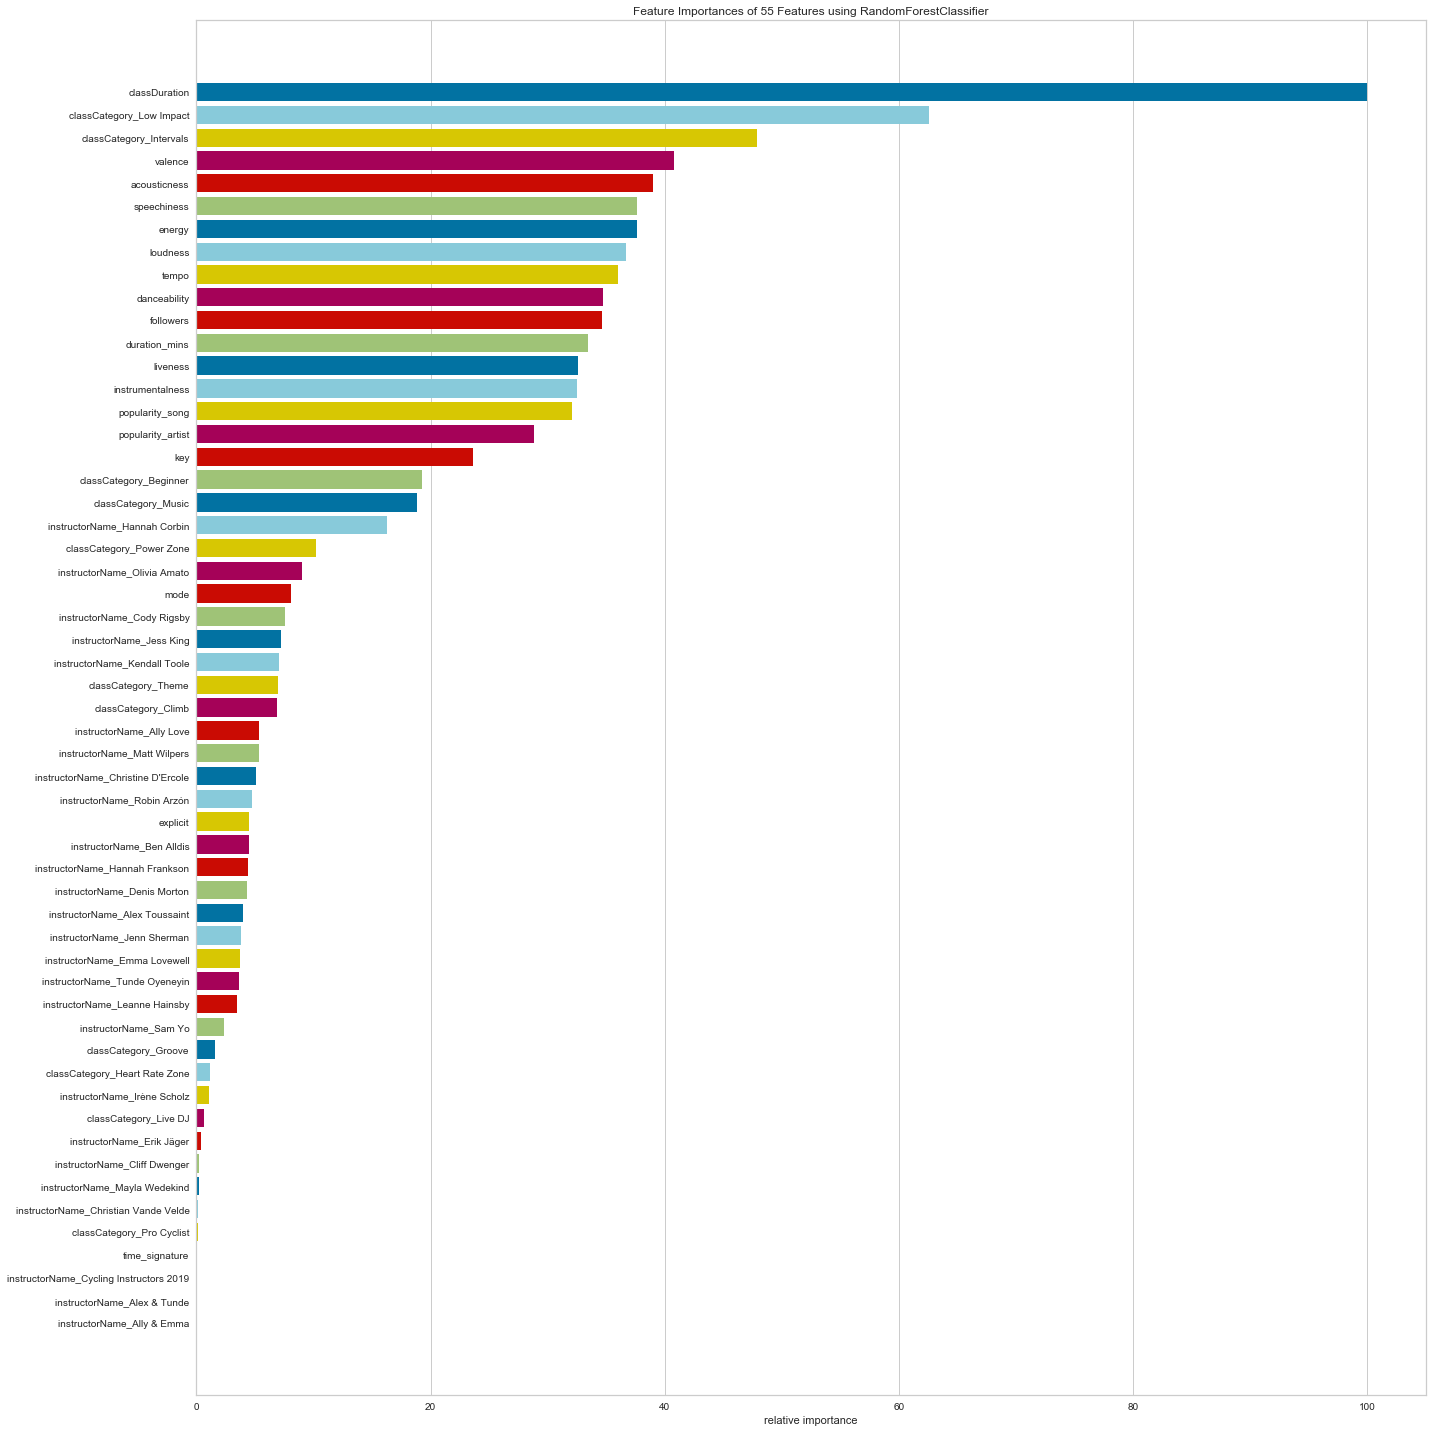

In [77]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf3)
viz.fit(X, y)
viz.show()

### Data V4 (No classCategory NOR className)
Trying this to see how much I can focus on instructors and music
Also class category has Beginner which leaks info on to the difficulty being Beginner

In [78]:
# Define X and y 

# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation', 'classCategory'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [79]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['instructorName']

#### Numeric Treatment - Scale

In [80]:
# Copy df for manipulation
scaled_features = df.copy()

In [81]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [82]:
# Copy df for manipulation
ohe_features = df.copy()

In [83]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,instructorName_Alex & Tunde,instructorName_Alex Toussaint,instructorName_Ally & Emma,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christian Vande Velde,instructorName_Christine D'Ercole,instructorName_Cliff Dwenger,instructorName_Cody Rigsby,instructorName_Cycling Instructors 2019,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Erik Jäger,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Irène Scholz,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Mayla Wedekind,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine - Data Version 3 - no classLocation, less OHE

In [85]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [86]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'instructorName_Alex & Tunde', 'instructorName_Alex Toussaint', 'instructorName_Ally & Emma', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christian Vande Velde', 'instructorName_Christine D'Ercole', 'instructorName_Cliff Dwenger', 'instructorName_Cody Rigsby', 'instructorName_Cycling Instructors 2019', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Erik Jäger', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Irène Scholz', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Mayla Wedekind',
       'instructorName_Olivia 

#### Model 7 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [87]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [88]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [89]:
# Instantiate
dt4 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt4.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.55      0.54      0.55       459
    Beginner       0.49      0.52      0.51       426
Intermediate       0.62      0.61      0.61       861

    accuracy                           0.57      1746
   macro avg       0.55      0.56      0.56      1746
weighted avg       0.57      0.57      0.57      1746

Train Scores
------------
Accuracy: 0.9996181019667749
F1 Score: 0.9996181019667749
--------------------
Test Scores
-----------
Accuracy: 0.5687285223367697
F1 Score: 0.5687285223367697
F1 Score Mean Cross Val 3-Fold: 0.5495511640196011


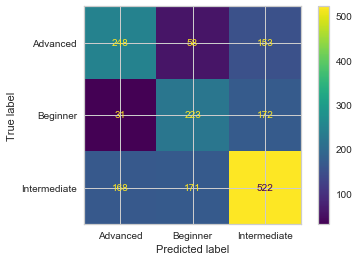

In [90]:
# Try micro 
eval_model(dt4, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [91]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

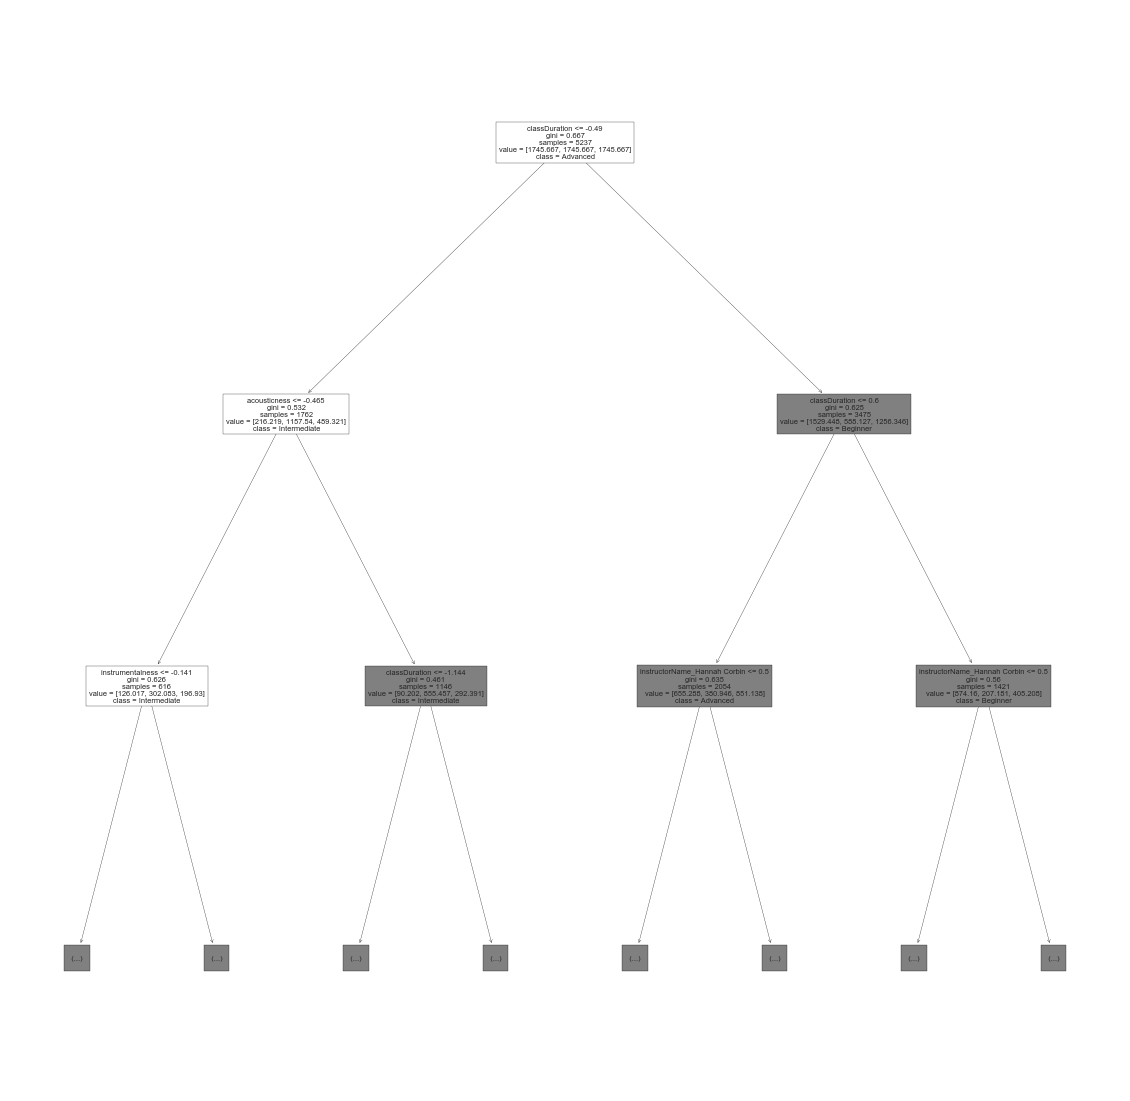

In [92]:
plt.figure(figsize=(20,20))
plot_tree(dt4, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


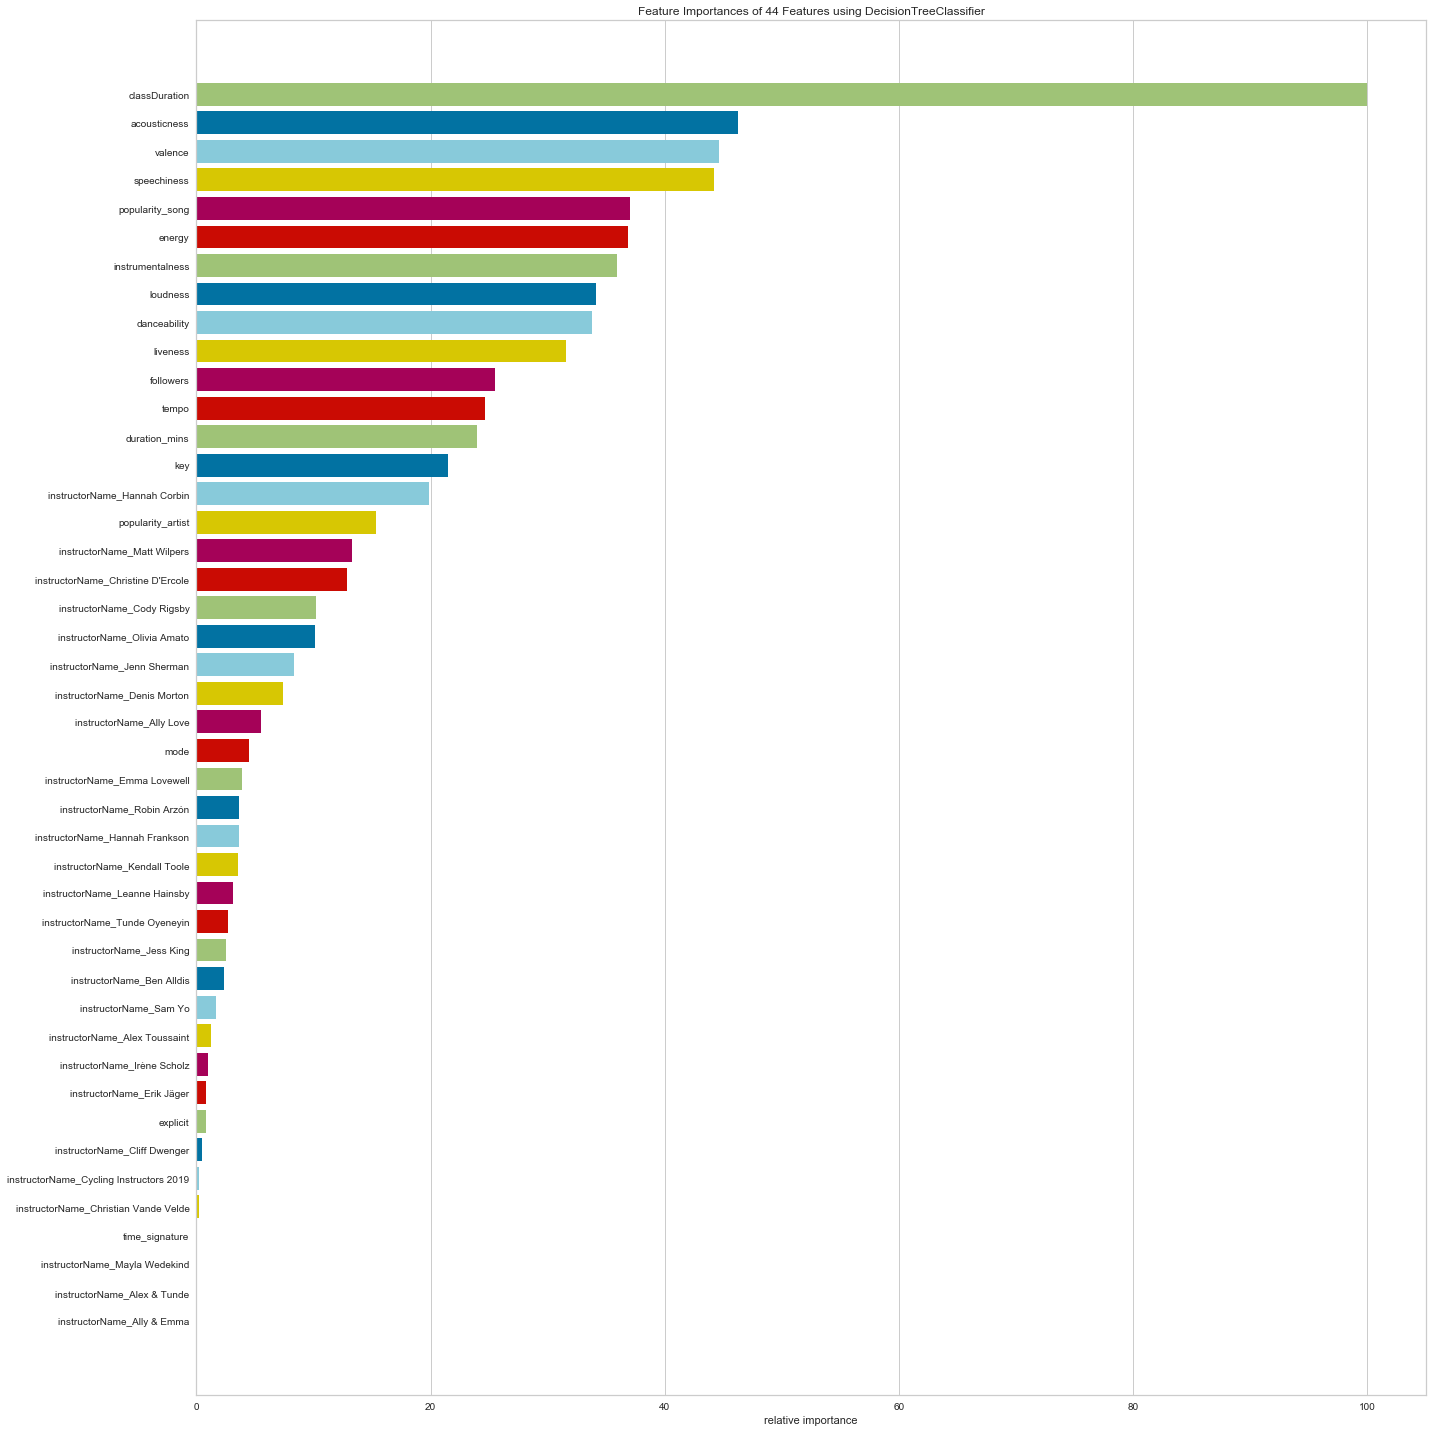

In [93]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt4)
viz.fit(X, y)
viz.show()

#### Model 8 - RF with Balanced Class Weight 

Class weight = 'balanced' to account for 25-50-25 split of Target

In [94]:
# Instantiate
rf4 = RandomForestClassifier(class_weight='balanced')

# Fit
rf4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Advanced       0.73      0.45      0.56       459
    Beginner       0.68      0.56      0.61       426
Intermediate       0.63      0.81      0.71       861

    accuracy                           0.65      1746
   macro avg       0.68      0.61      0.63      1746
weighted avg       0.67      0.65      0.64      1746

Train Scores
------------
Accuracy: 0.9996181019667749
F1 Score: 0.9996181019667749
--------------------
Test Scores
-----------
Accuracy: 0.6540664375715922
F1 Score: 0.6540664375715922
F1 Score Mean Cross Val 3-Fold: 0.6389138880409964


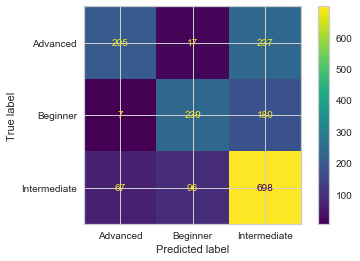

In [95]:
# Try micro 
eval_model(rf4, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


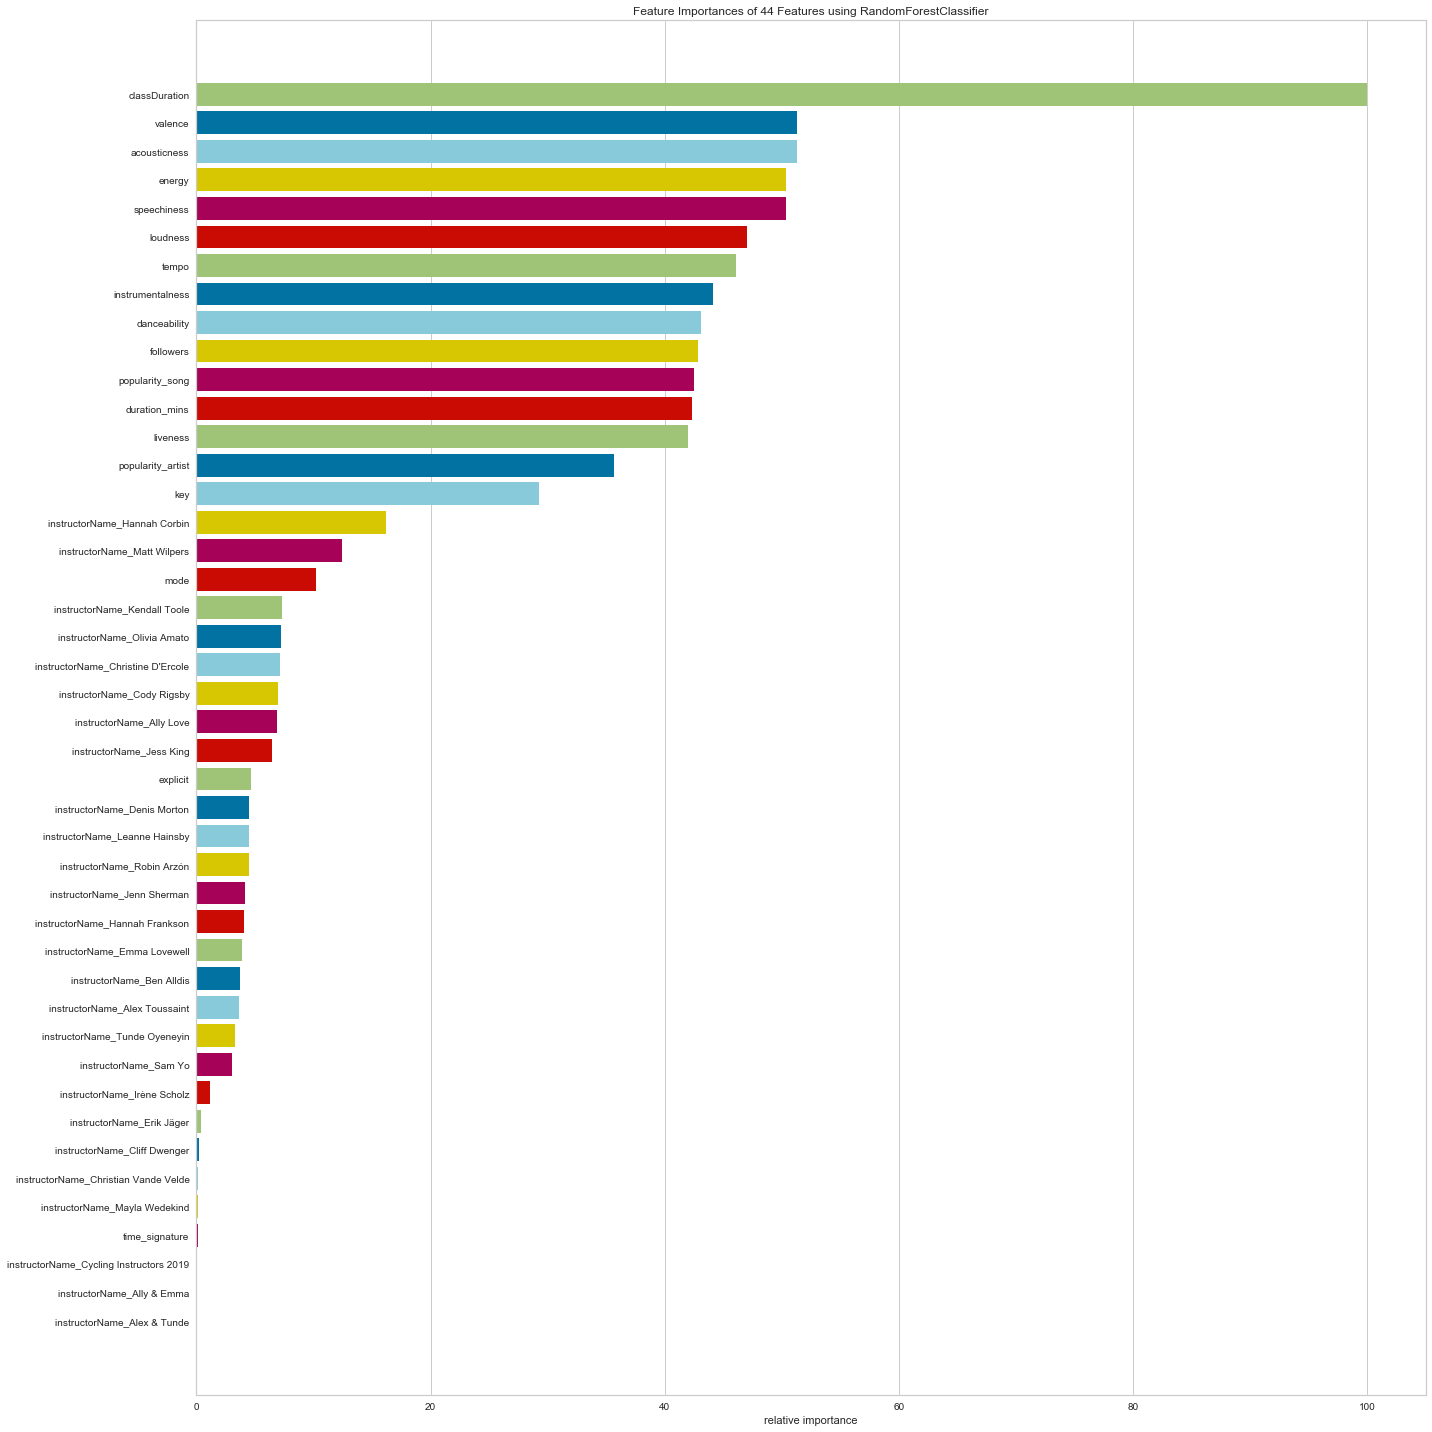

In [96]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf4)
viz.fit(X, y)
viz.show()

Ideas to try:
- make classDuration Categorical
- drop classCategory Beginner
- Tune trees

### Data v5 (add back in classCategory - drop Beginner ; make classDuration Categorical)

In [97]:
# Define X and y 

# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [98]:
# Replace className with classCategory in ohe_cols
num_cols = ['popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName', 'classDuration']

#### Numeric Treatment - Scale

In [99]:
# Copy df for manipulation
scaled_features = df.copy()

In [100]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [101]:
# Copy df for manipulation
ohe_features = df.copy()

In [102]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classDuration,classCategory_Beginner,classCategory_Climb,classCategory_Groove,classCategory_Heart Rate Zone,classCategory_Intervals,classCategory_Live DJ,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Pro Cyclist,classCategory_Theme,instructorName_Alex & Tunde,instructorName_Alex Toussaint,instructorName_Ally & Emma,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christian Vande Velde,instructorName_Christine D'Ercole,instructorName_Cliff Dwenger,instructorName_Cody Rigsby,instructorName_Cycling Instructors 2019,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Erik Jäger,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Irène Scholz,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Mayla Wedekind,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,20,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,20,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,30,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
ohe_features = pd.get_dummies(ohe_features)

In [104]:
# dropping beginnger to account for leakage
ohe_features.drop(columns='classCategory_Beginner', inplace=True)

In [105]:
ohe_features

,classDuration,classCategory_Climb,classCategory_Groove,classCategory_Heart Rate Zone,classCategory_Intervals,classCategory_Live DJ,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Pro Cyclist,classCategory_Theme,instructorName_Alex & Tunde,instructorName_Alex Toussaint,instructorName_Ally & Emma,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christian Vande Velde,instructorName_Christine D'Ercole,instructorName_Cliff Dwenger,instructorName_Cody Rigsby,instructorName_Cycling Instructors 2019,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Erik Jäger,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Irène Scholz,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Mayla Wedekind,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,20,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6978,30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6979,20,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6980,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6981,45,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Combine - Data Version 3 - no classLocation, less OHE

In [106]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [107]:
# Review available columns, check work
preprocessed.columns

Index(['popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classDuration', 'classCategory_Climb', 'classCategory_Groove', 'classCategory_Heart Rate Zone', 'classCategory_Intervals', 'classCategory_Live DJ', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Pro Cyclist', 'classCategory_Theme', 'instructorName_Alex & Tunde', 'instructorName_Alex Toussaint', 'instructorName_Ally & Emma', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christian Vande Velde', 'instructorName_Christine D'Ercole', 'instructorName_Cliff Dwenger', 'instructorName_Cody Rigsby', 'instructorName_Cycling Instructors 2019', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Erik Jäger', 'instructorName_Hannah Corbin',
       'instructorNa

In [108]:
len(preprocessed.columns)

55

#### Model 9 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [109]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [110]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [111]:
# Instantiate
dt5 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt5.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.64      0.62      0.63       459
    Beginner       0.70      0.72      0.71       426
Intermediate       0.69      0.69      0.69       861

    accuracy                           0.68      1746
   macro avg       0.67      0.67      0.67      1746
weighted avg       0.68      0.68      0.68      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.6764032073310424
F1 Score: 0.6764032073310424
F1 Score Mean Cross Val 3-Fold: 0.6671766056074685


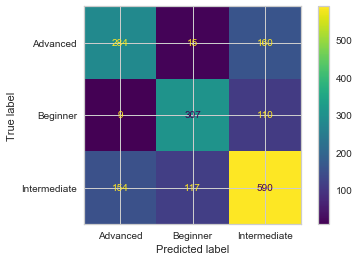

In [112]:
# Try micro 
eval_model(dt5, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [113]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

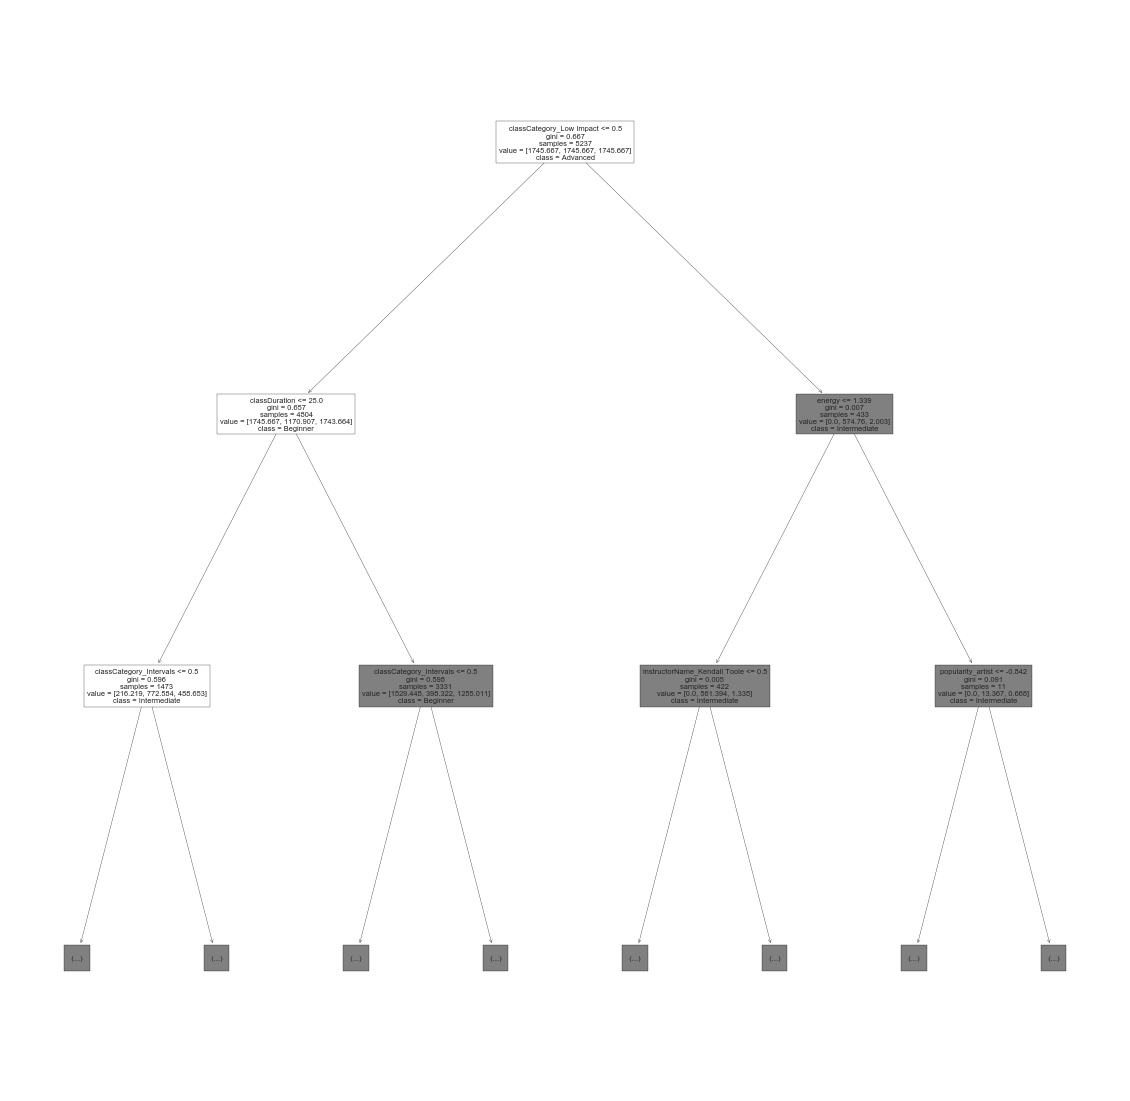

In [114]:
plt.figure(figsize=(20,20))
plot_tree(dt5, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


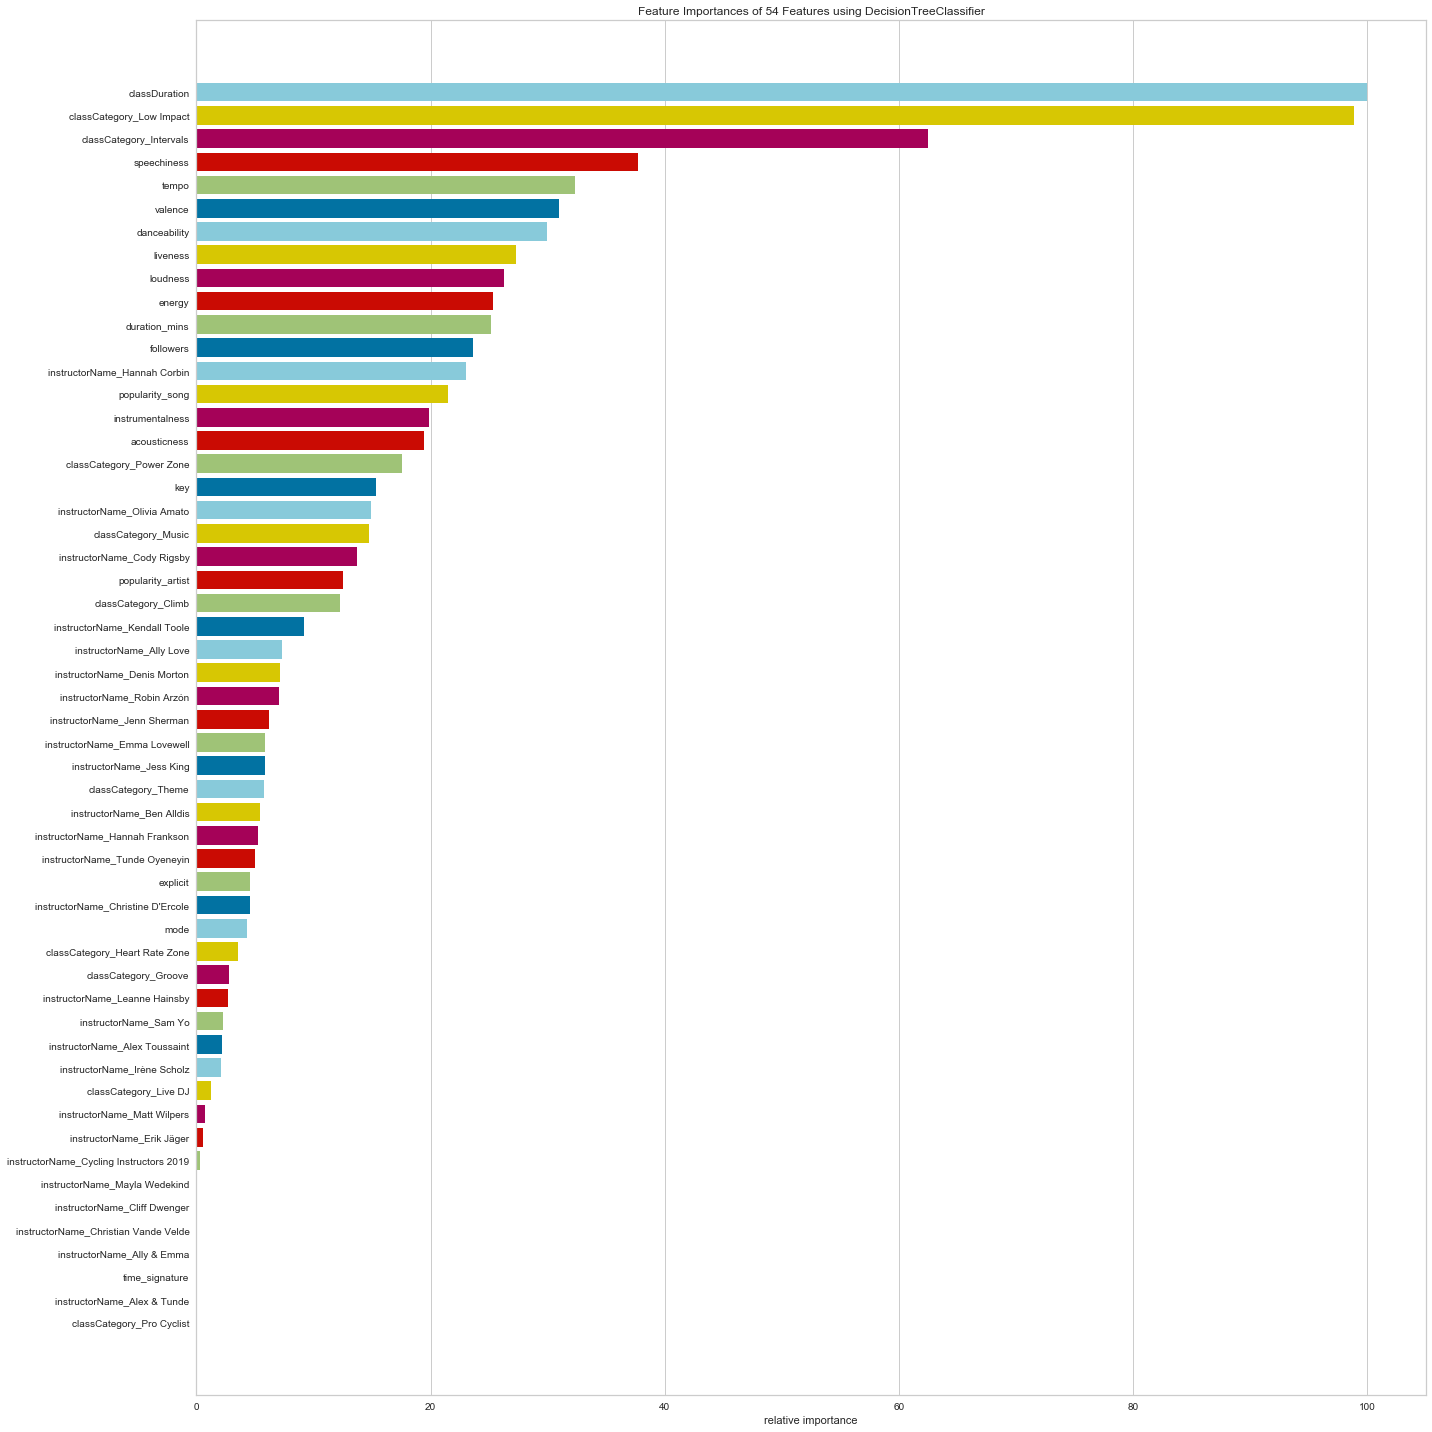

In [115]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt5)
viz.fit(X, y)
viz.show()

#### Model 6 - RF with Balanced Class Weight 

Class weight = 'balanced' to account for 25-50-25 split of Target

In [116]:
# Instantiate
rf5 = RandomForestClassifier(class_weight='balanced')

# Fit
rf5.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Advanced       0.81      0.58      0.68       459
    Beginner       0.86      0.68      0.76       426
Intermediate       0.70      0.88      0.78       861

    accuracy                           0.75      1746
   macro avg       0.79      0.71      0.74      1746
weighted avg       0.77      0.75      0.75      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.7514318442153494
F1 Score: 0.7514318442153494
F1 Score Mean Cross Val 3-Fold: 0.7296162821611084


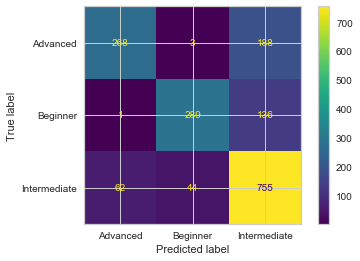

In [117]:
# Try micro 
eval_model(rf5, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


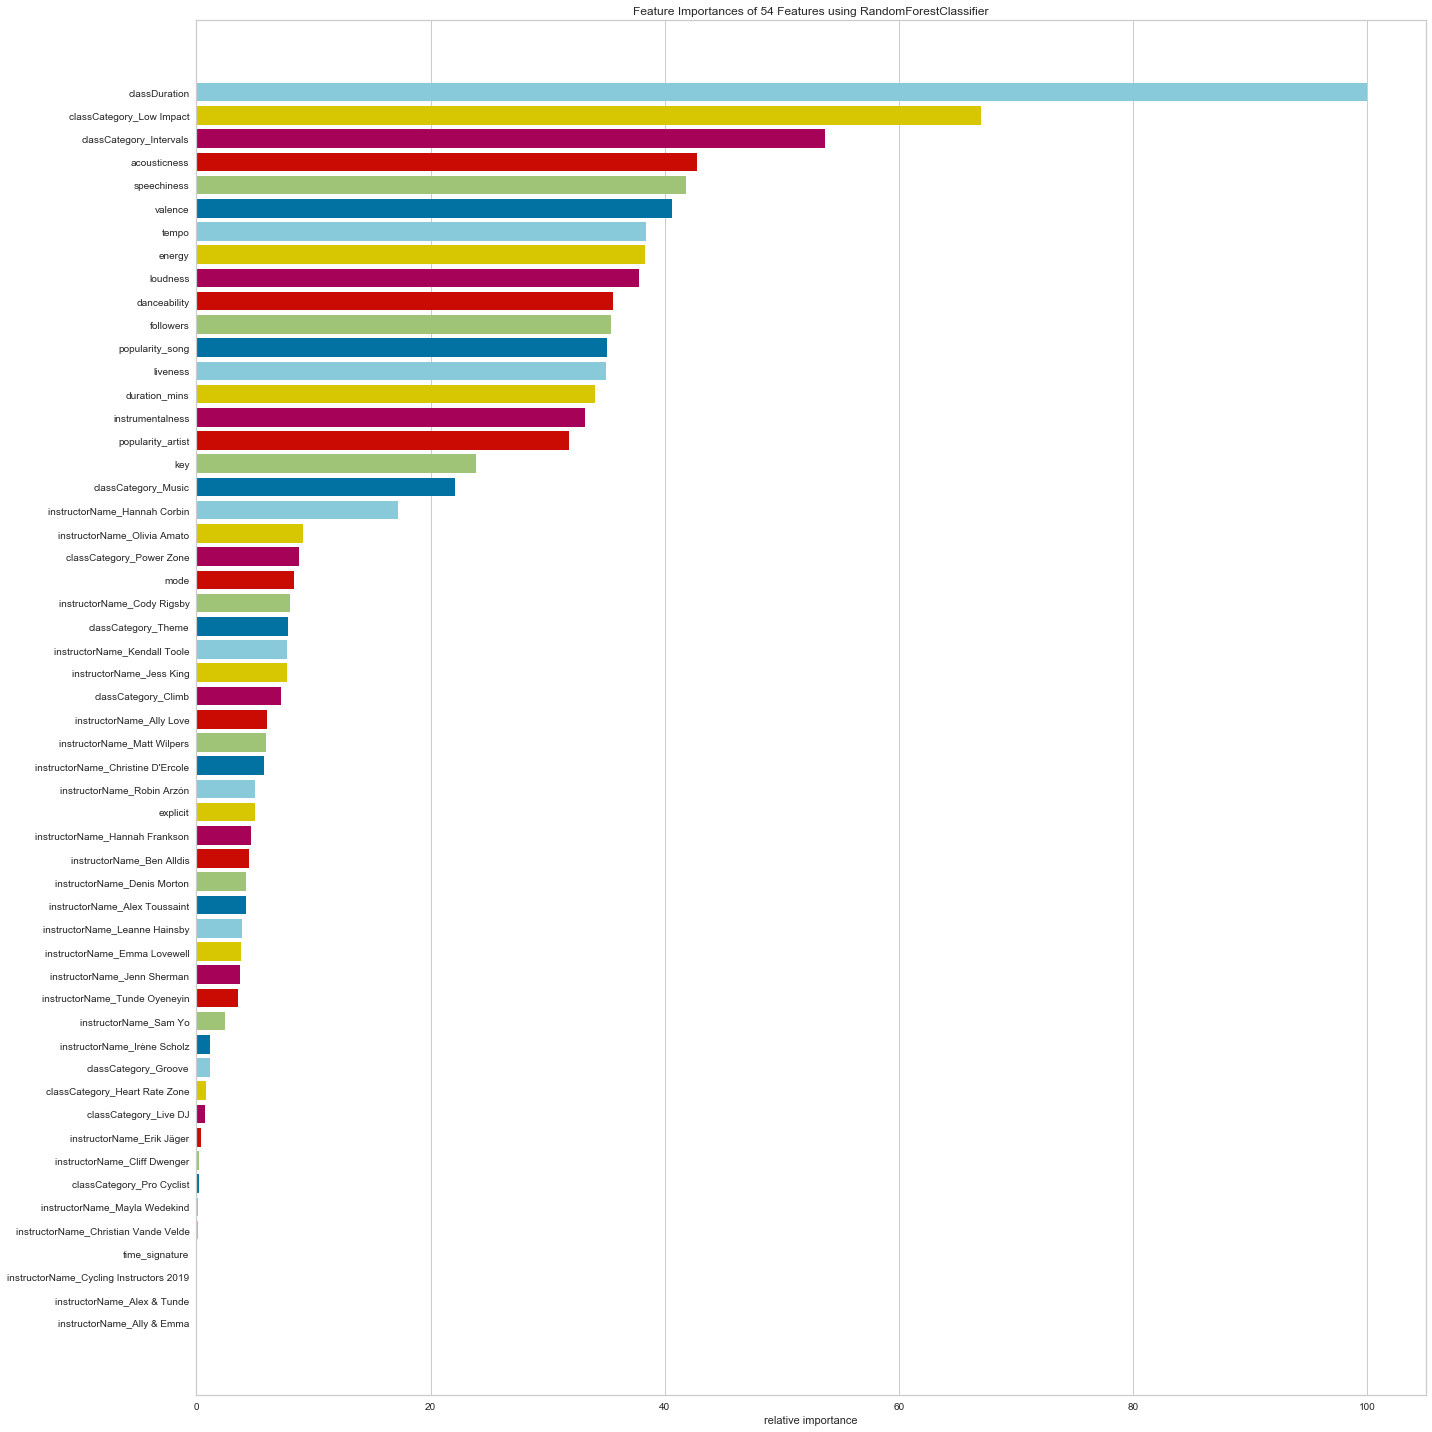

In [118]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf5)
viz.fit(X, y)
viz.show()

### Data Analysis for other options

In [119]:
df['instructorName'].value_counts()

Ben Alldis                  588
Leanne Hainsby              580
Ally Love                   493
Cody Rigsby                 442
Hannah Corbin               416
Alex Toussaint              410
Jess King                   408
Emma Lovewell               406
Christine D'Ercole          386
Jenn Sherman                376
Sam Yo                      328
Hannah Frankson             324
Matt Wilpers                321
Robin Arzón                 312
Tunde Oyeneyin              299
Denis Morton                288
Kendall Toole               284
Olivia Amato                241
Irène Scholz                 40
Christian Vande Velde        14
Erik Jäger                   14
Cliff Dwenger                 6
Alex & Tunde                  3
Mayla Wedekind                2
Cycling Instructors 2019      1
Ally & Emma                   1
Name: instructorName, dtype: int64

In [120]:
other_instructors = ['Irène Scholz', 'Erik Jäger', 'Christian Vande Velde', 'Cliff Dwenger',
                     'Alex & Tunde', 'Mayla Wedekind', 'Ally & Emma', 'Cycling Instructors 2019']

df['instructorName'] = df['instructorName'].replace(other_instructors, 'Other')

In [121]:
df['instructorName'].value_counts()

Ben Alldis            588
Leanne Hainsby        580
Ally Love             493
Cody Rigsby           442
Hannah Corbin         416
Alex Toussaint        410
Jess King             408
Emma Lovewell         406
Christine D'Ercole    386
Jenn Sherman          376
Sam Yo                328
Hannah Frankson       324
Matt Wilpers          321
Robin Arzón           312
Tunde Oyeneyin        299
Denis Morton          288
Kendall Toole         284
Olivia Amato          241
Other                  81
Name: instructorName, dtype: int64

In [122]:
df['classCategory'].value_counts()

Music              3030
Intervals          1709
Theme               743
Low Impact          556
Power Zone          307
Climb               249
Beginner            223
Groove               71
Heart Rate Zone      41
Live DJ              40
Pro Cyclist          14
Name: classCategory, dtype: int64

In [123]:
# Recategorize low count classes
# Create Other category for those <50 
# Put Groove Cody classes into Theme - not a music genre or year, but a programmatic type class like XOXO
df['classCategory'] = df['classCategory'].replace({'Heart Rate Zone' : 'Other',
                                                   'Live DJ' : 'Other',
                                                   'Pro Cyclist' : 'Other',
                                                   'Groove': 'Theme'})                                               

In [124]:
df['classCategory'].value_counts()

Music         3030
Intervals     1709
Theme          814
Low Impact     556
Power Zone     307
Climb          249
Beginner       223
Other           95
Name: classCategory, dtype: int64

In [125]:
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory,classDifficulty_cat
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0,3.611225,Music,Beginner
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0,5.703883,Intervals,Intermediate
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5,3.729600,Beginner,Intermediate
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0,3.624000,Music,Intermediate
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0,3.800000,Music,Beginner


In [126]:
df[df['classCategory'] == 'Beginner']['classDifficulty_cat'].value_counts()

Beginner        195
Intermediate     28
Name: classDifficulty_cat, dtype: int64

### Data V6 (condense instructors and class categories)

In [127]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [128]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [129]:
# Copy df for manipulation
scaled_features = df.copy()

In [130]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [131]:
# Copy df for manipulation
ohe_features = df.copy()

In [132]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [133]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine

In [134]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [135]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Other', 'classCategory_Power Zone', 'classCategory_Theme', 'instructorName_Alex Toussaint', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christine D'Ercole', 'instructorName_Cody Rigsby', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Olivia Amato', 'instructorName_Other', 'instructorName_Robin Arzón',
       'instr

In [136]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_cat
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Beginner
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Intermediate
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Intermediate
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Beginner


#### Model 11 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [137]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [138]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [139]:
# Instantiate
dt6 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt6.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.63      0.61      0.62       459
    Beginner       0.73      0.75      0.74       426
Intermediate       0.70      0.70      0.70       861

    accuracy                           0.69      1746
   macro avg       0.69      0.69      0.69      1746
weighted avg       0.69      0.69      0.69      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.6890034364261168
F1 Score: 0.6890034364261168
F1 Score Mean Cross Val 3-Fold: 0.668513540569193


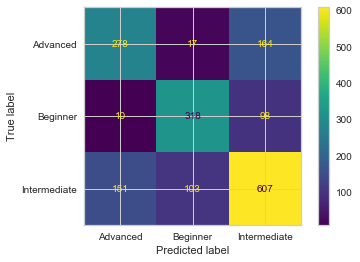

In [140]:
# Try micro 
eval_model(dt6, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [141]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

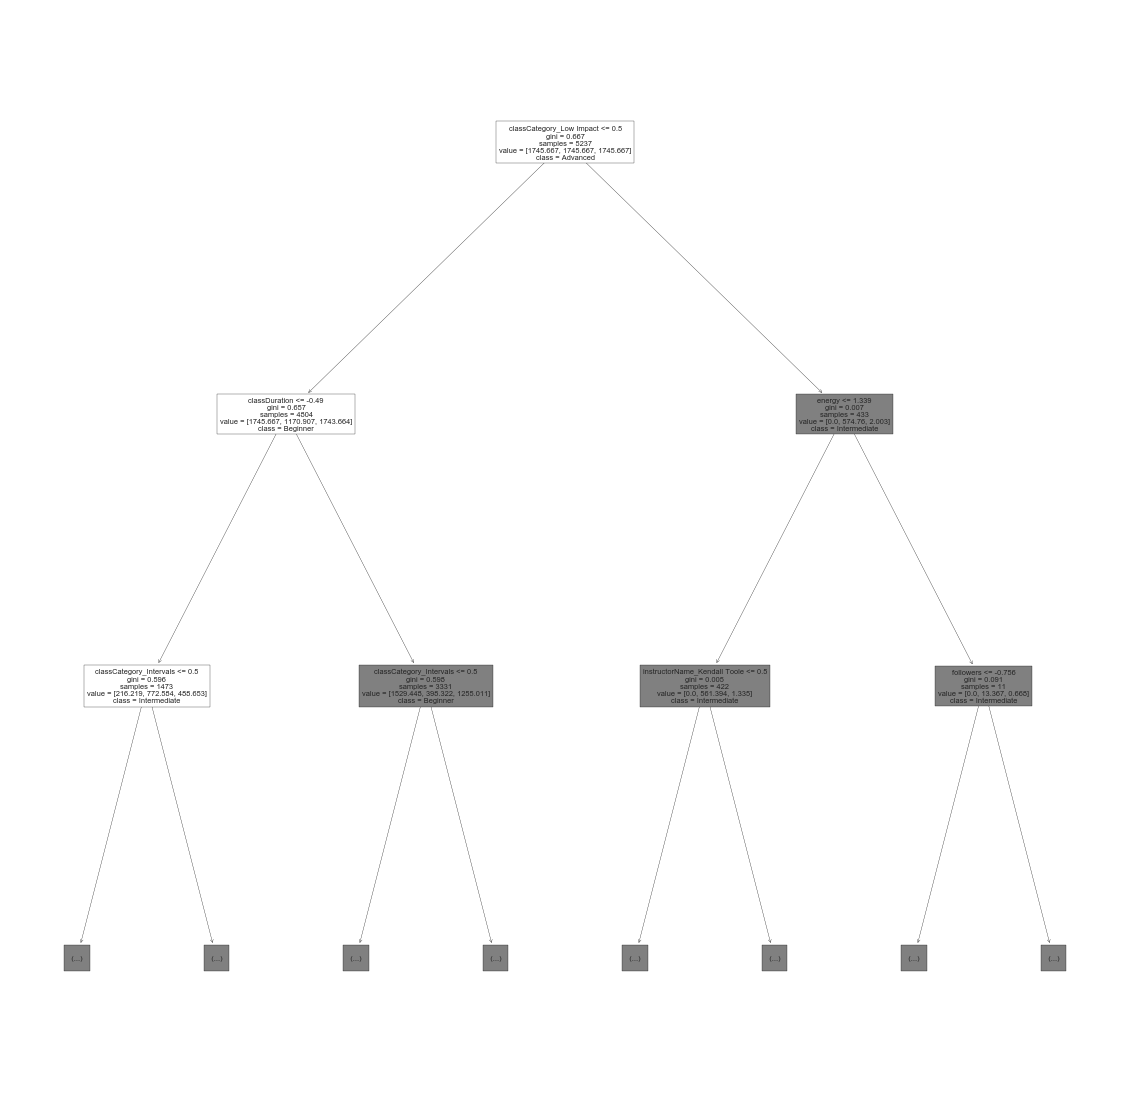

In [142]:
plt.figure(figsize=(20,20))
plot_tree(dt6, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


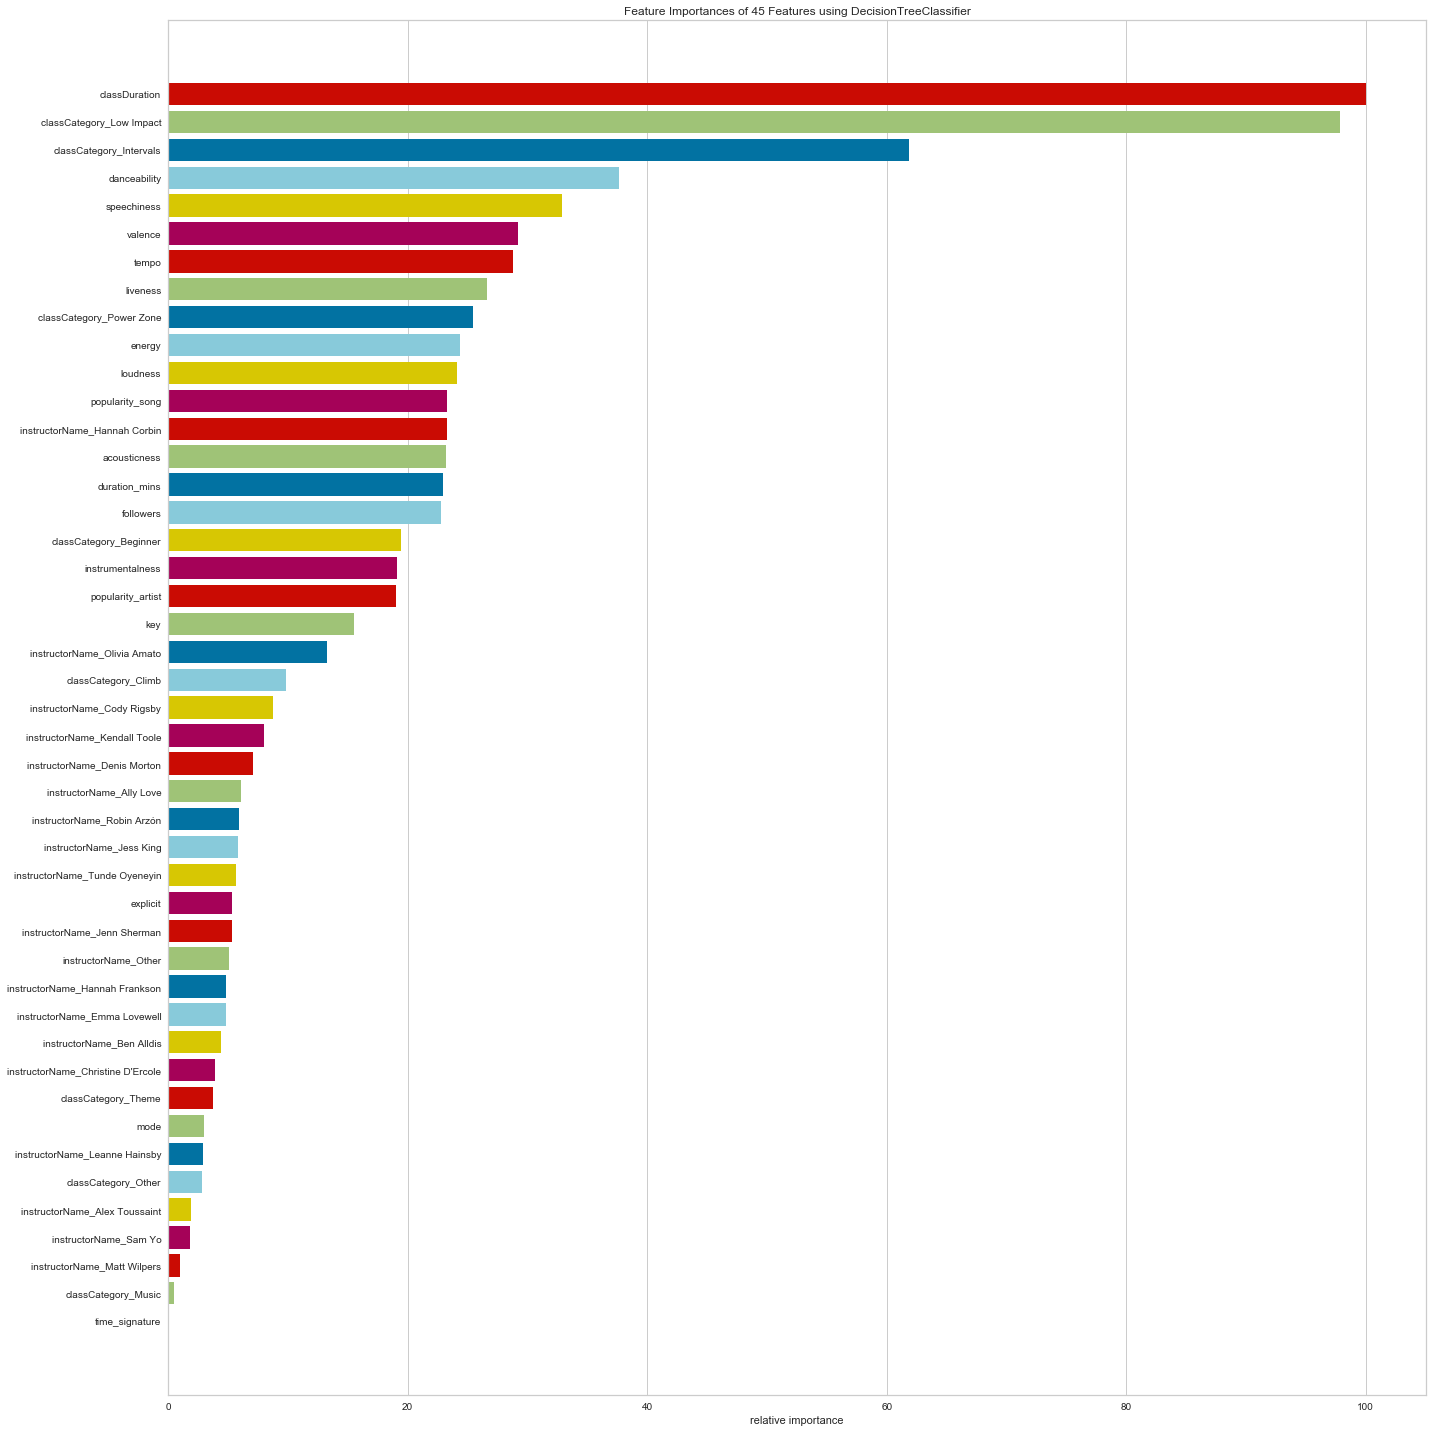

In [143]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt6)
viz.fit(X, y)
viz.show()

#### Model 12 - RF with Balanced Class Weight 

Class weight = 'balanced' to account for 25-50-25 split of Target

In [144]:
# Instantiate
rf6 = RandomForestClassifier(class_weight='balanced')

# Fit
rf6.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Advanced       0.79      0.56      0.66       459
    Beginner       0.82      0.71      0.76       426
Intermediate       0.70      0.85      0.77       861

    accuracy                           0.74      1746
   macro avg       0.77      0.71      0.73      1746
weighted avg       0.75      0.74      0.74      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.7422680412371134
F1 Score: 0.7422680412371134
F1 Score Mean Cross Val 3-Fold: 0.7292336911986573


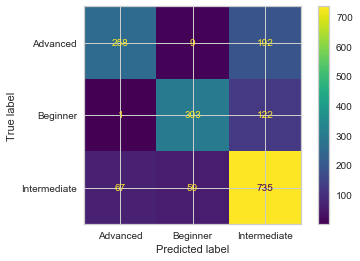

In [145]:
# Try micro 
eval_model(rf6, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


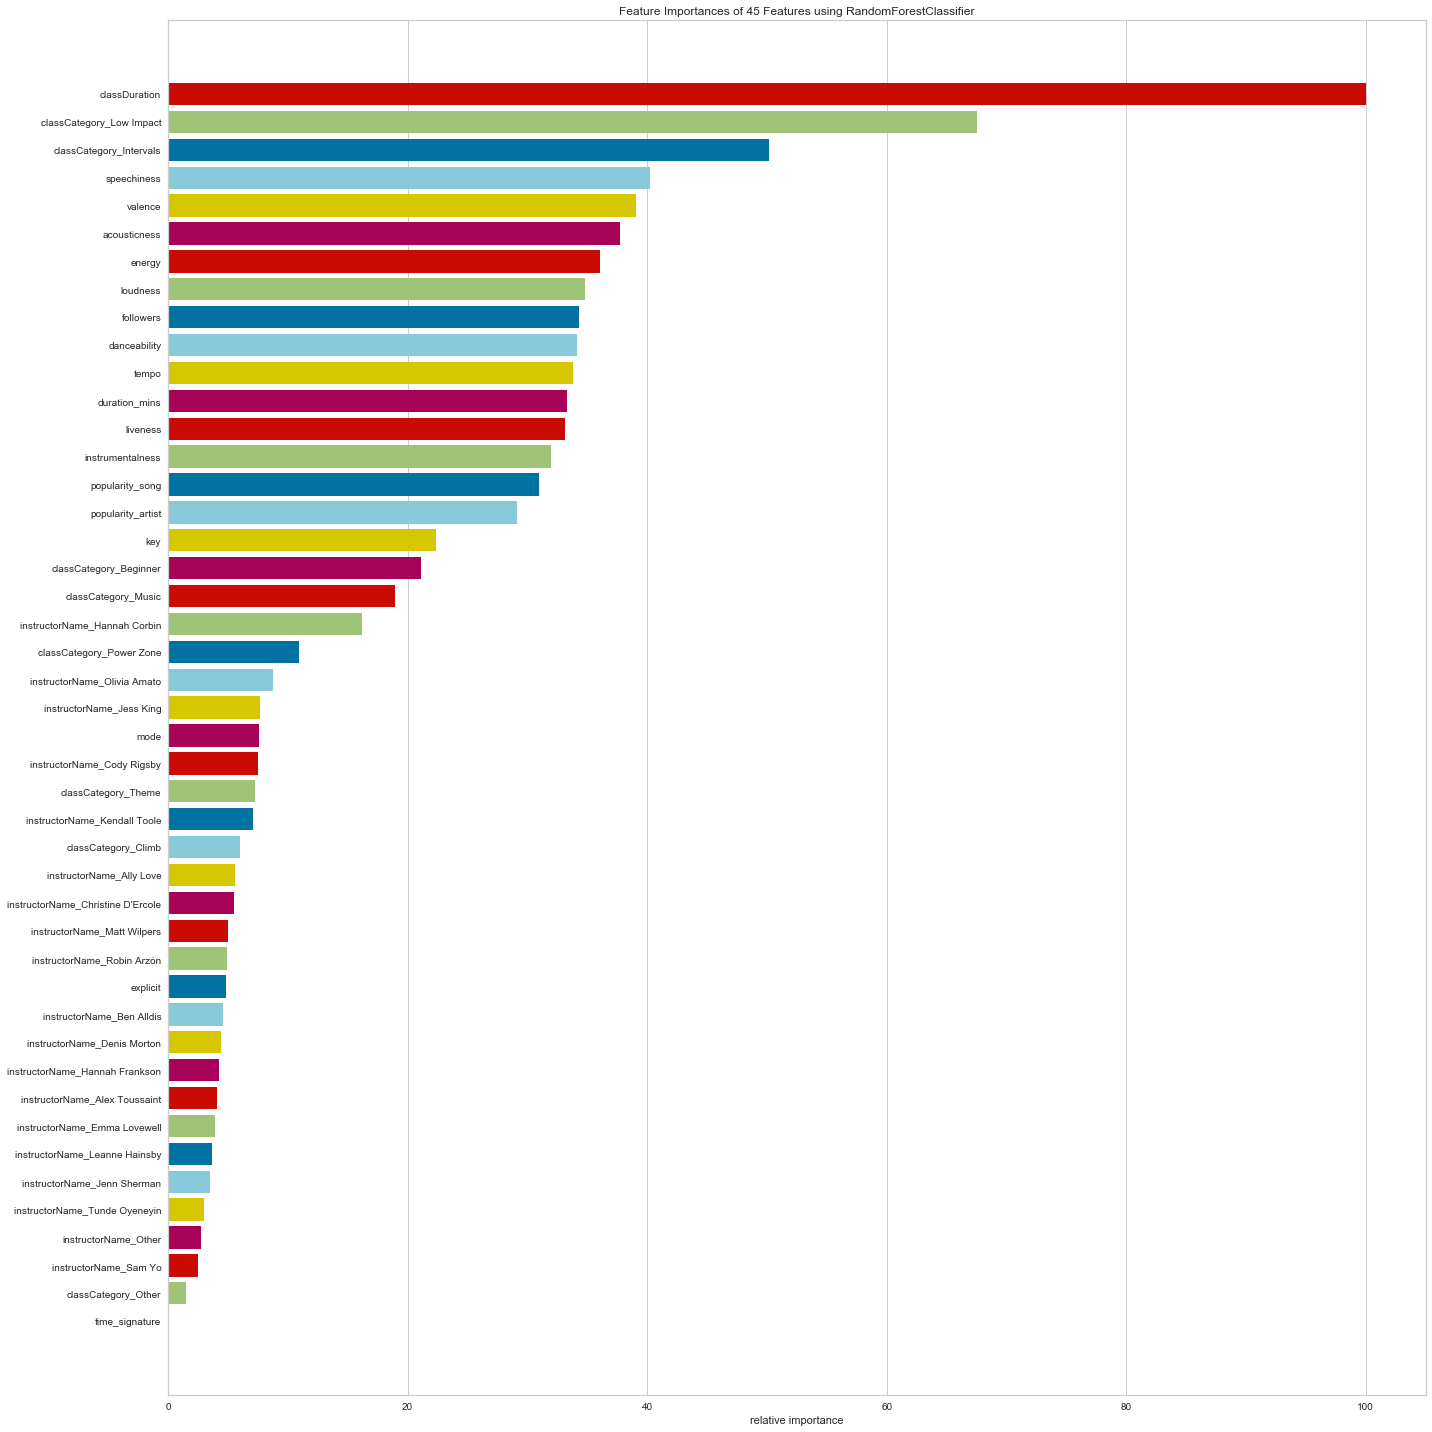

In [146]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf6)
viz.fit(X, y)
viz.show()

### Data V7 (drop 'Other' categories and time signature- not impactful)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983 entries, 0 to 6982
Data columns (total 36 columns):
classId                 6983 non-null object
className               6983 non-null object
classDescription        6983 non-null object
classDifficulty         6983 non-null float64
classDuration           6983 non-null int64
classType               6983 non-null object
classLength             6983 non-null int64
classLocation           6983 non-null object
classOriginalAirdate    6983 non-null object
classRating             6983 non-null float64
classRatingCount        6983 non-null int64
instructorName          6983 non-null object
instructorBio           6983 non-null object
classEquipment          6983 non-null object
classSongs              6983 non-null object
classArtists            6983 non-null object
classUrl                6983 non-null object
popularity_song         6983 non-null float64
explicit                6983 non-null float64
danceability            6983 non-null

In [148]:
df.groupby(by=['instructorName','classDifficulty_cat'])['classId'].count()
# Hannah Corbin has a lot of Beginner rides

instructorName      classDifficulty_cat
Alex Toussaint      Advanced               172
                    Beginner                38
                    Intermediate           200
Ally Love           Advanced               179
                    Beginner                42
                    Intermediate           272
Ben Alldis          Advanced               122
                    Beginner               117
                    Intermediate           349
Christine D'Ercole  Advanced                43
                    Beginner               190
                    Intermediate           153
Cody Rigsby         Advanced                31
                    Beginner                82
                    Intermediate           329
Denis Morton        Advanced                23
                    Beginner               103
                    Intermediate           162
Emma Lovewell       Advanced               124
                    Beginner                73
                    

In [149]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation', 'time_signature'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [150]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [151]:
# Copy df for manipulation
scaled_features = df.copy()

In [152]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [153]:
# Copy df for manipulation
ohe_features = df.copy()

In [154]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [155]:
ohe_features = pd.get_dummies(ohe_features)

In [156]:
# Drop Other categories and reset index
ohe_features = ohe_features.drop(columns=['classCategory_Other', 'instructorName_Other']).reset_index(drop=True)

#### Combine

In [157]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [158]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Theme', 'instructorName_Alex Toussaint', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christine D'Ercole', 'instructorName_Cody Rigsby', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Olivia Amato', 'instructorName_Robin Arzón', 'instructorName_Sam Yo', 'instructorName_Tunde Oyeneyin',
       'classDifficu

In [159]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_cat
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Beginner
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Intermediate
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Intermediate
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Beginner


#### Model 13 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [160]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [161]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [162]:
# Instantiate
dt7 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt7.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.61      0.59      0.60       459
    Beginner       0.73      0.76      0.74       426
Intermediate       0.70      0.70      0.70       861

    accuracy                           0.68      1746
   macro avg       0.68      0.68      0.68      1746
weighted avg       0.68      0.68      0.68      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.6838487972508591
F1 Score: 0.6838487972508591
F1 Score Mean Cross Val 3-Fold: 0.6692778472502573


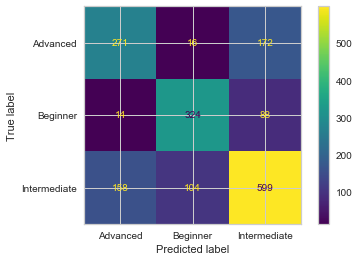

In [163]:
# Try micro 
eval_model(dt7, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [164]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

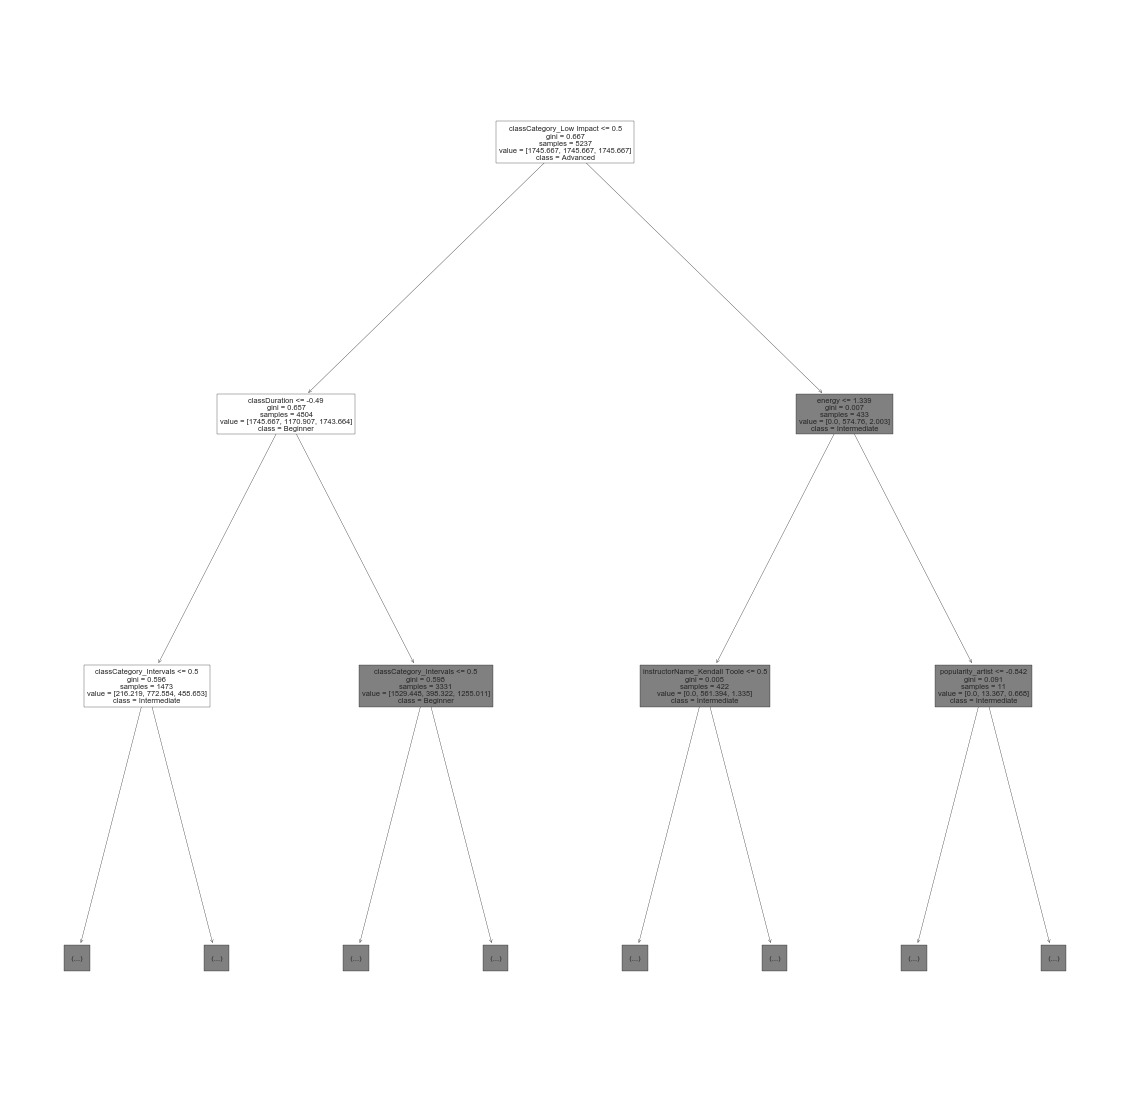

In [165]:
plt.figure(figsize=(20,20))
plot_tree(dt7, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


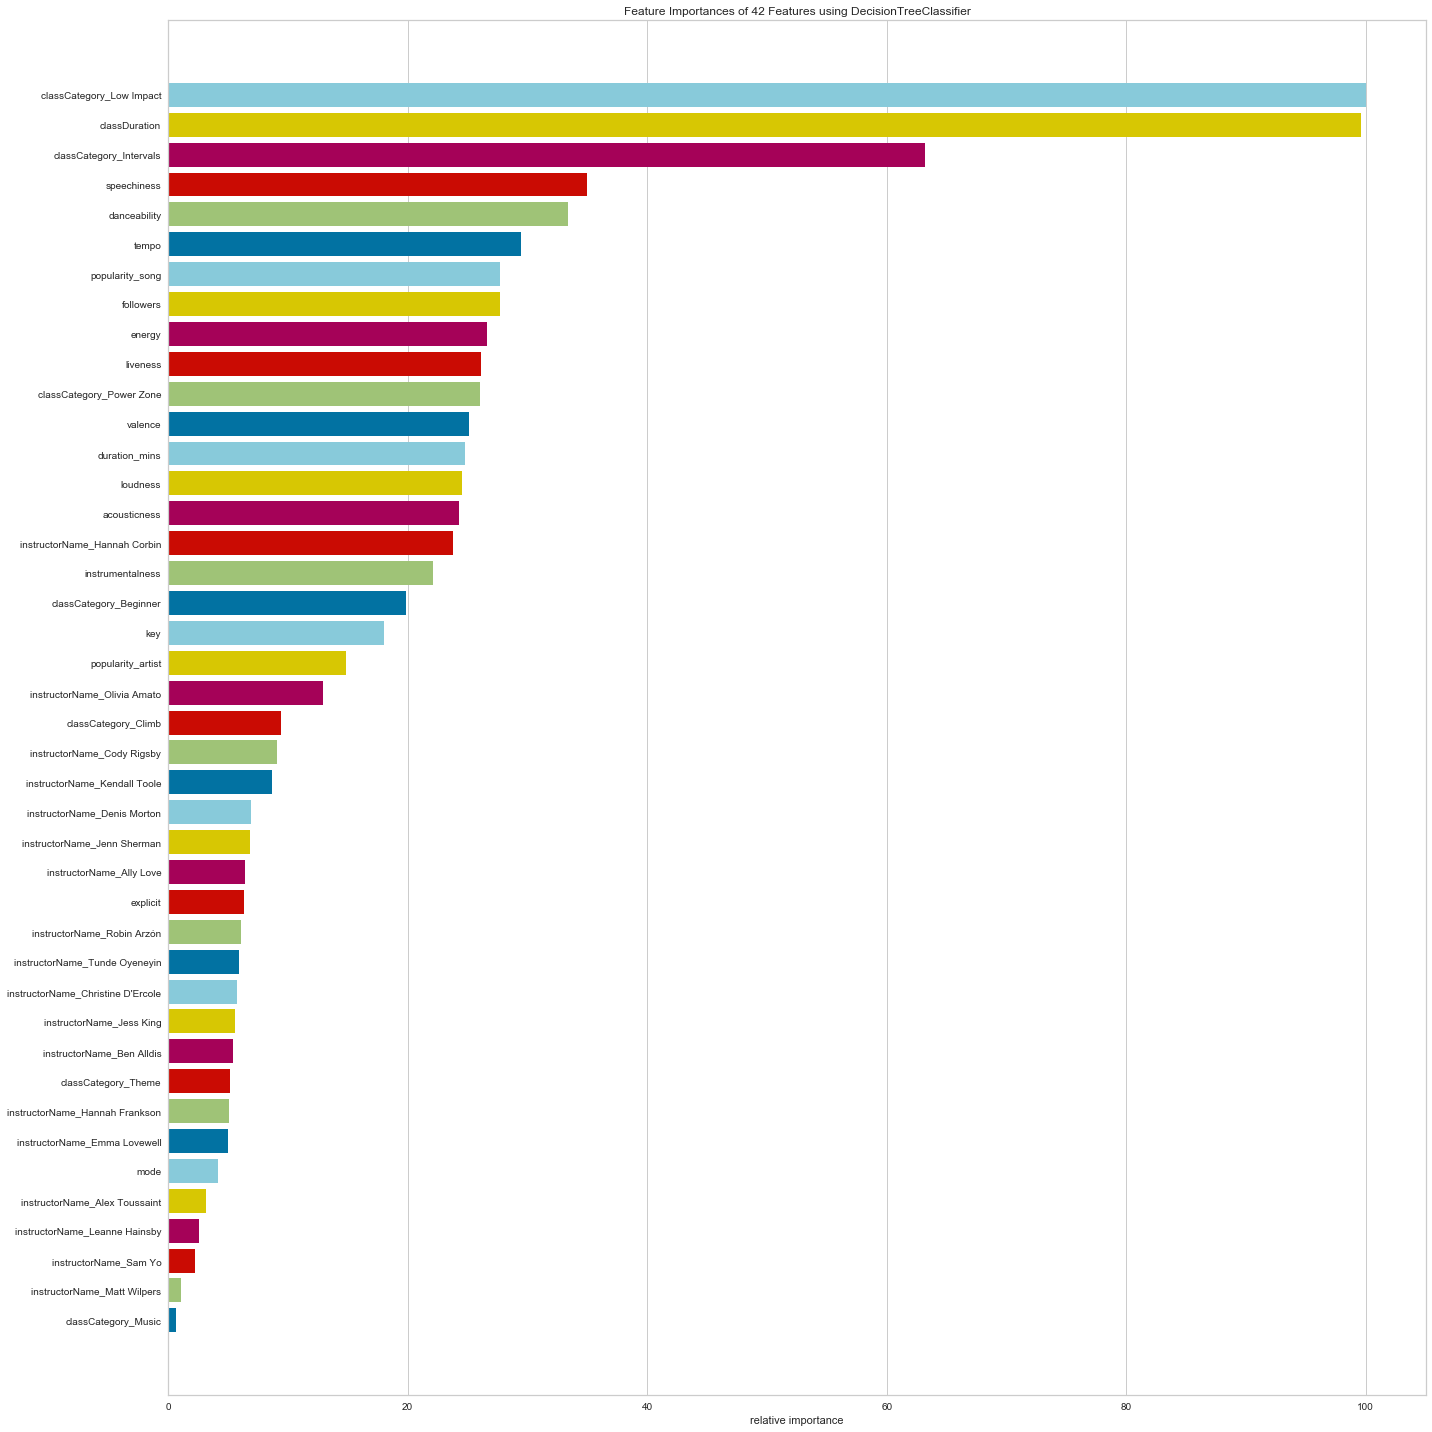

In [166]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt7)
viz.fit(X, y)
viz.show()

#### Model 14 - RF with Balanced Class Weight 

Class weight = 'balanced' to account for 25-50-25 split of Target

In [167]:
# Instantiate
rf7 = RandomForestClassifier(class_weight='balanced')

# Fit
rf7.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Advanced       0.80      0.59      0.68       459
    Beginner       0.82      0.70      0.76       426
Intermediate       0.70      0.86      0.77       861

    accuracy                           0.75      1746
   macro avg       0.78      0.72      0.74      1746
weighted avg       0.76      0.75      0.74      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.7479954180985109
F1 Score: 0.7479954180985109
F1 Score Mean Cross Val 3-Fold: 0.733433876969162


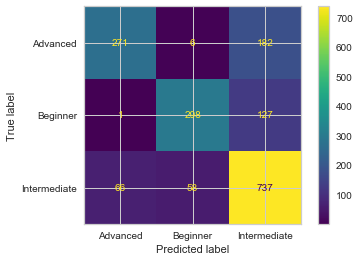

In [168]:
# Try micro 
eval_model(rf7, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


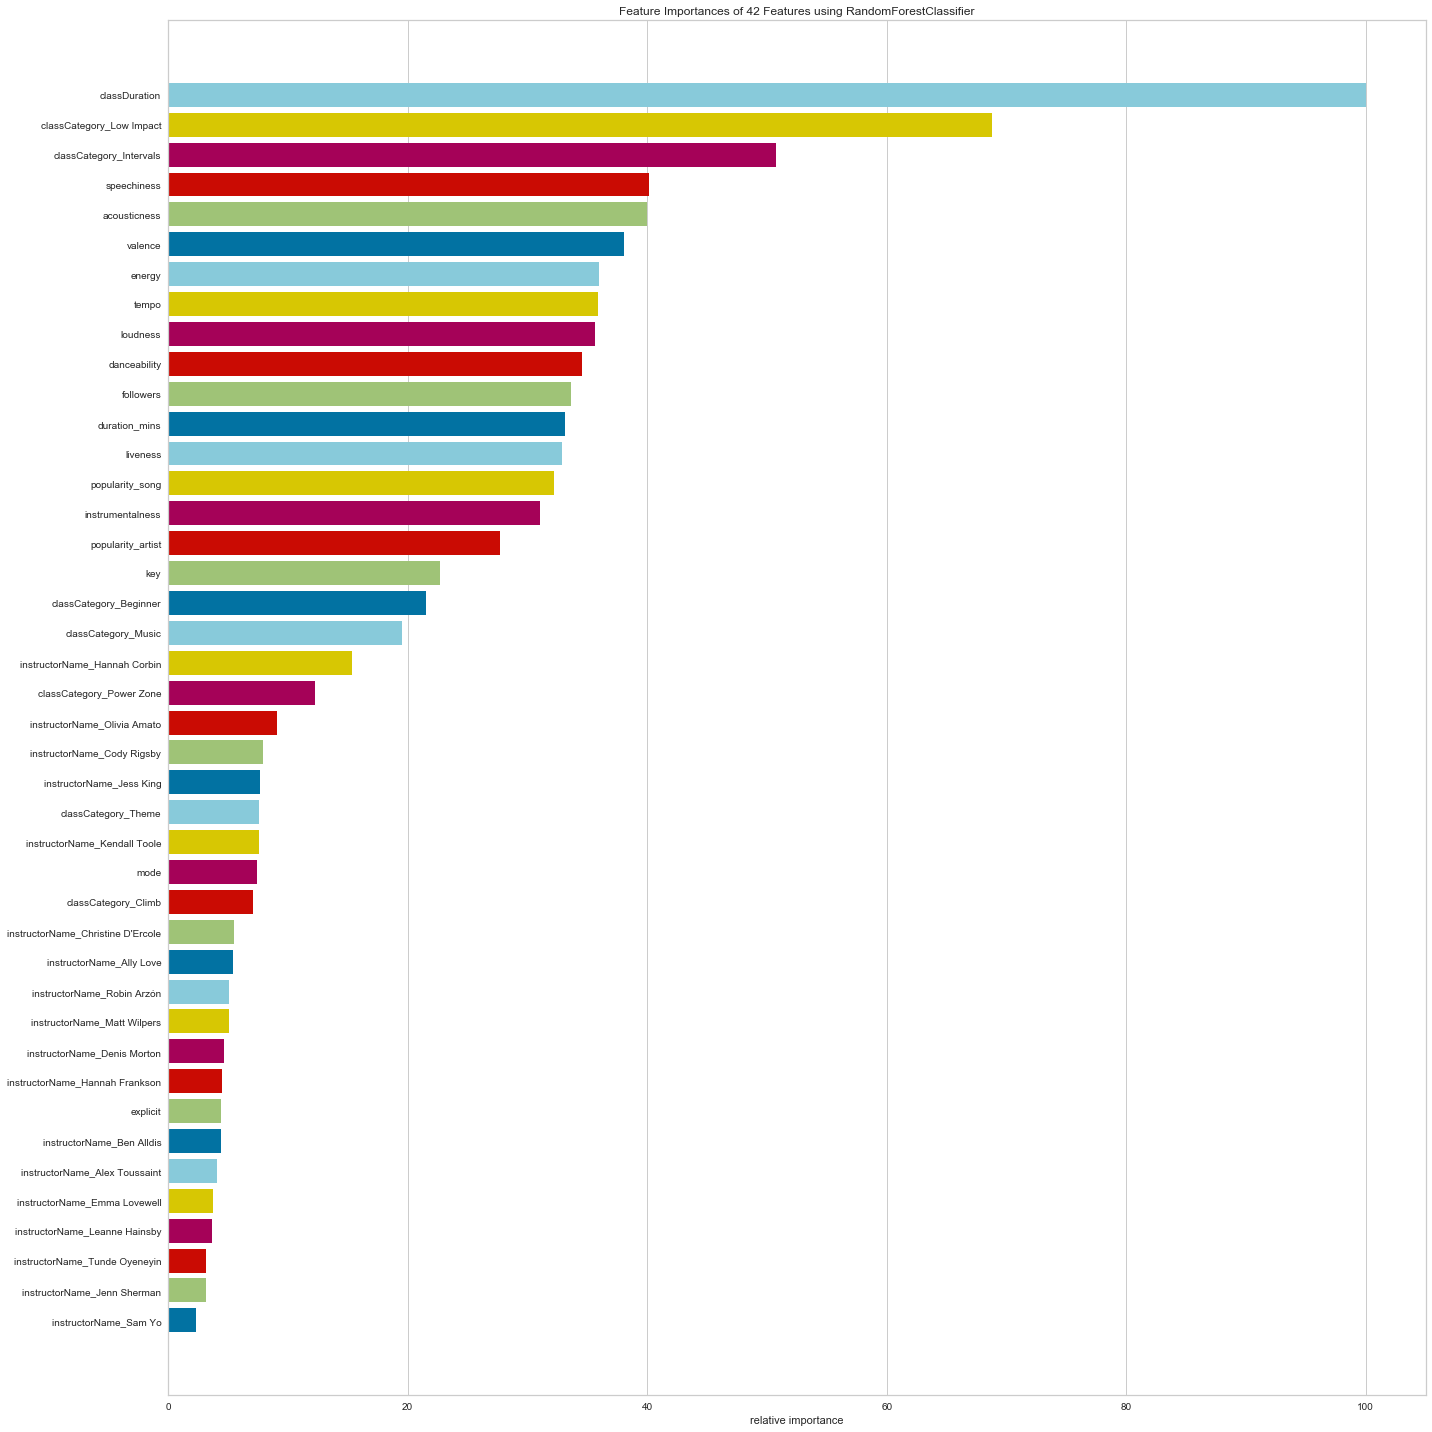

In [169]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf7)
viz.fit(X, y)
viz.show()

### Bonus Model, KNN

In [170]:
# Instantiate
knn = KNeighborsClassifier()

# Fit
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

              precision    recall  f1-score   support

    Advanced       0.55      0.56      0.56       459
    Beginner       0.67      0.53      0.59       426
Intermediate       0.63      0.69      0.66       861

    accuracy                           0.62      1746
   macro avg       0.62      0.60      0.60      1746
weighted avg       0.62      0.62      0.62      1746

Train Scores
------------
Accuracy: 0.7376360511743365
F1 Score: 0.7376360511743365
--------------------
Test Scores
-----------
Accuracy: 0.6197021764032073
F1 Score: 0.6197021764032073
F1 Score Mean Cross Val 3-Fold: 0.5976678033896006


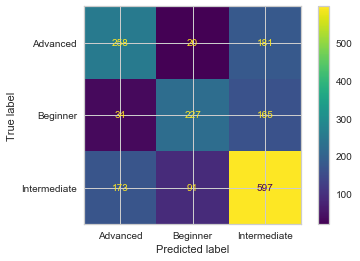

In [171]:
# Try micro 
eval_model(knn, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

### Data V8 (drop Instructors, 'Other' categories and time signature- not impactful)
Instructors are on feature importance list but mostly at bottom, so test without

In [172]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation', 'time_signature', 'instructorName'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [173]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory']

#### Numeric Treatment - Scale

In [174]:
# Copy df for manipulation
scaled_features = df.copy()

In [175]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [176]:
# Copy df for manipulation
ohe_features = df.copy()

In [177]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme
0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0


In [178]:
ohe_features = pd.get_dummies(ohe_features)

In [179]:
# Drop Other categories and reset index
ohe_features = ohe_features.drop(columns=['classCategory_Other']).reset_index(drop=True)

#### Combine

In [180]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [181]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Theme', 'classDifficulty_cat'], dtype='object')

In [182]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Theme,classDifficulty_cat
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,Beginner
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,Intermediate
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,Intermediate
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,Intermediate
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,Beginner


#### Model 14 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [183]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [184]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [185]:
# Instantiate
dt8 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt8.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.47      0.47      0.47       459
    Beginner       0.65      0.68      0.66       426
Intermediate       0.60      0.58      0.59       861

    accuracy                           0.58      1746
   macro avg       0.57      0.58      0.58      1746
weighted avg       0.58      0.58      0.58      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.5778923253150057
F1 Score: 0.5778923253150057
F1 Score Mean Cross Val 3-Fold: 0.6047383513250645


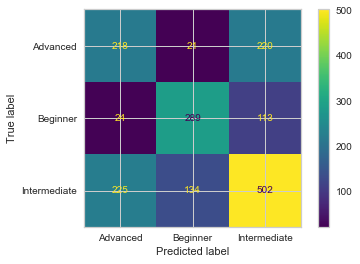

In [186]:
# Try micro 
eval_model(dt8, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [187]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

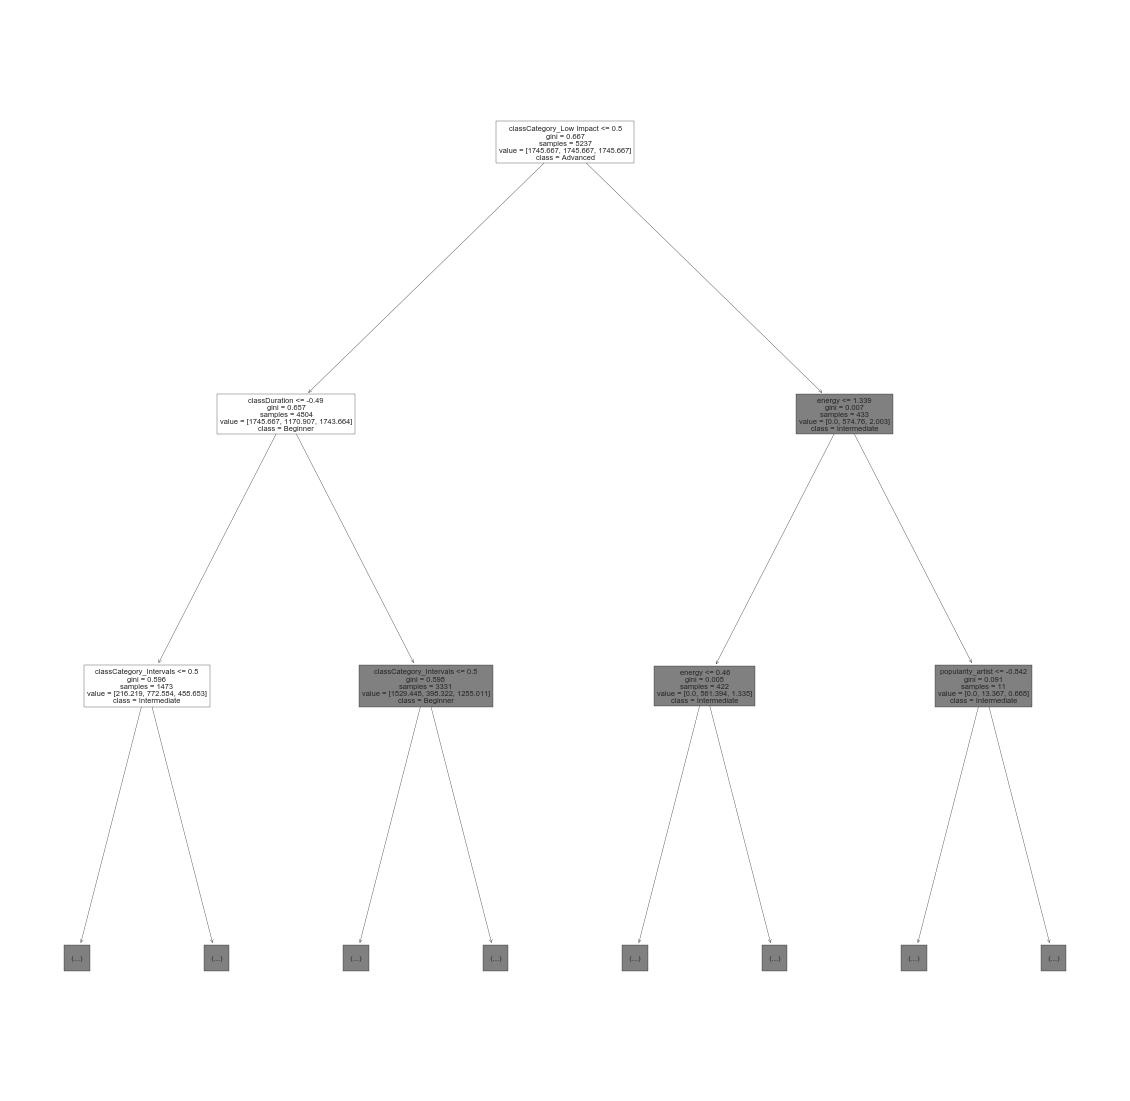

In [188]:
plt.figure(figsize=(20,20))
plot_tree(dt8, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


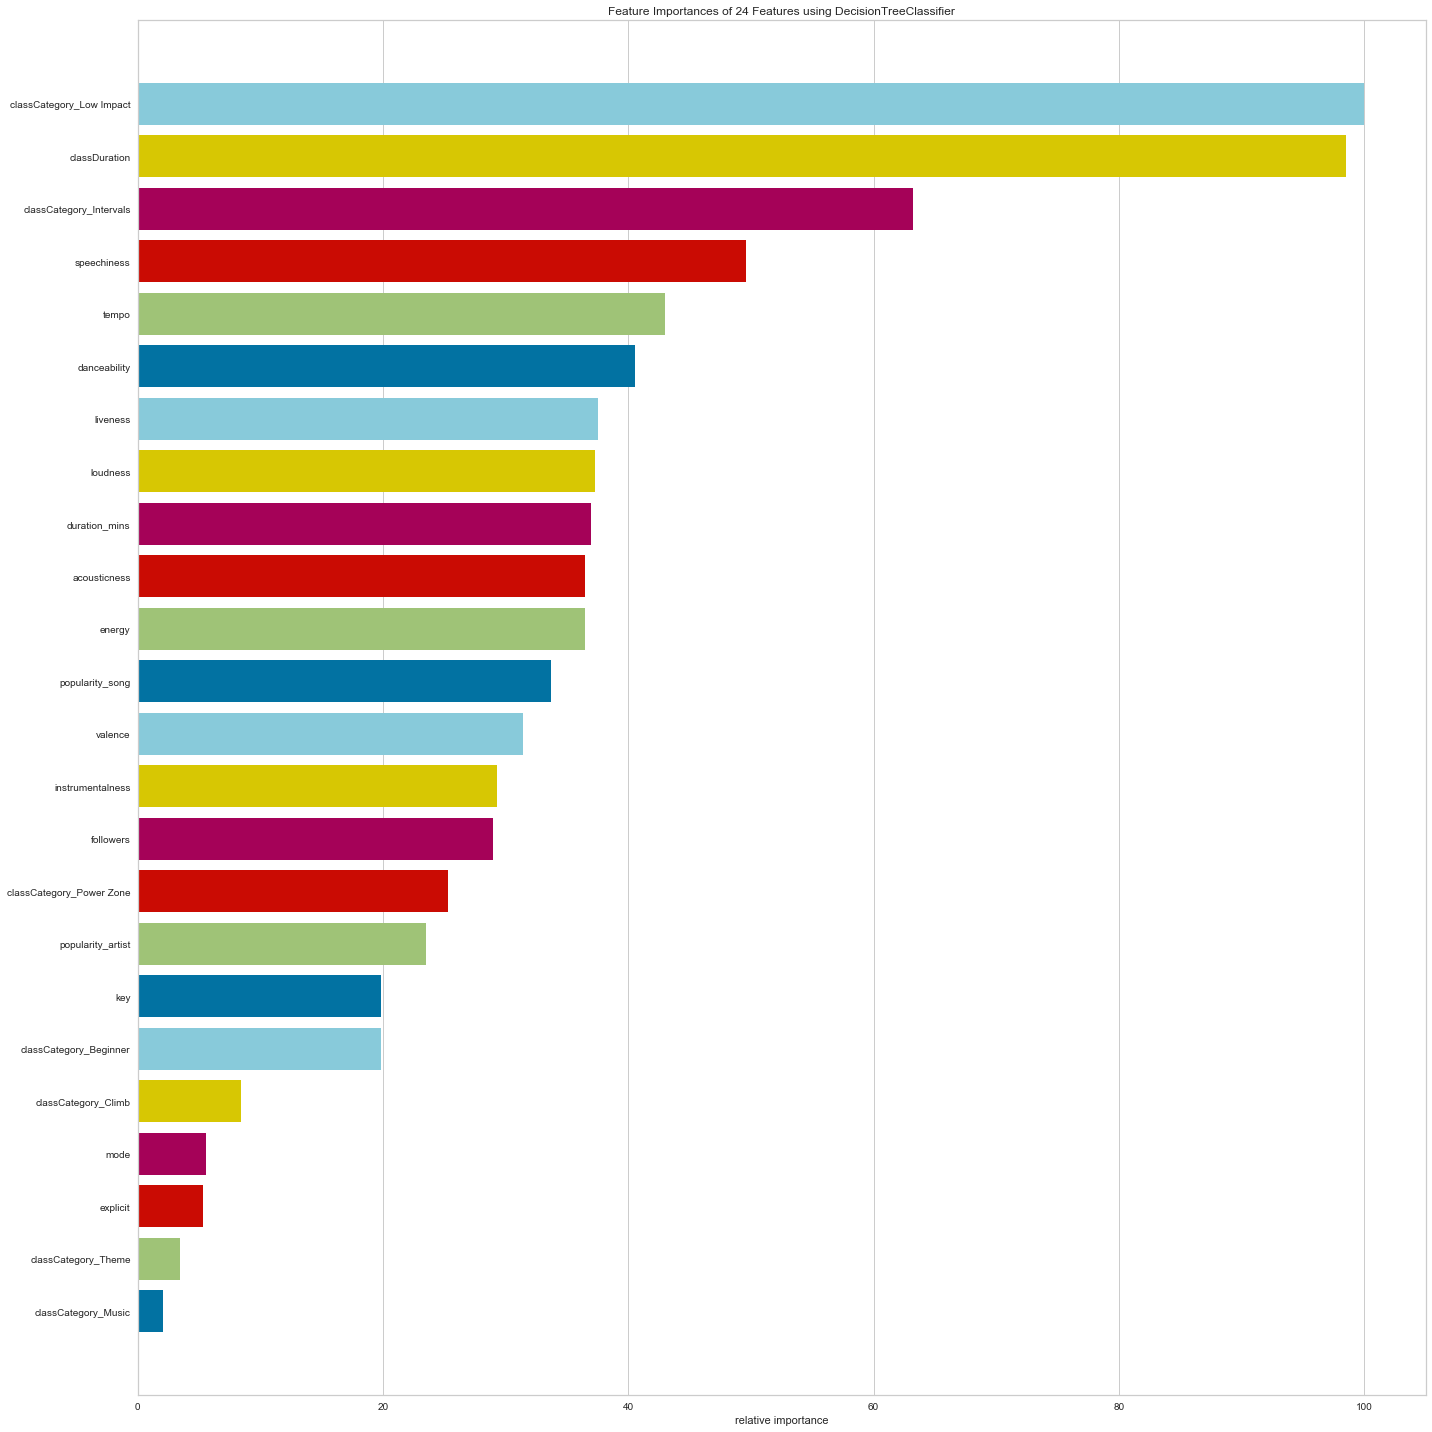

In [189]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt8)
viz.fit(X, y)
viz.show()

#### Model 16- RF with Balanced Class Weight 

Class weight = 'balanced' to account for 25-50-25 split of Target

In [190]:
# Instantiate
rf8 = RandomForestClassifier(class_weight='balanced')

# Fit
rf8.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Advanced       0.67      0.41      0.51       459
    Beginner       0.78      0.62      0.69       426
Intermediate       0.62      0.82      0.71       861

    accuracy                           0.66      1746
   macro avg       0.69      0.61      0.63      1746
weighted avg       0.67      0.66      0.65      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.6603665521191294
F1 Score: 0.6603665521191294
F1 Score Mean Cross Val 3-Fold: 0.6772950808014171


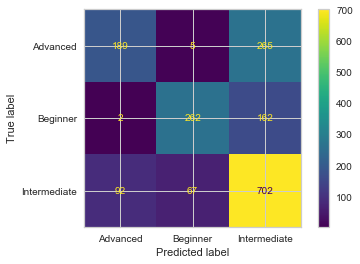

In [191]:
# Try micro 
eval_model(rf8, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


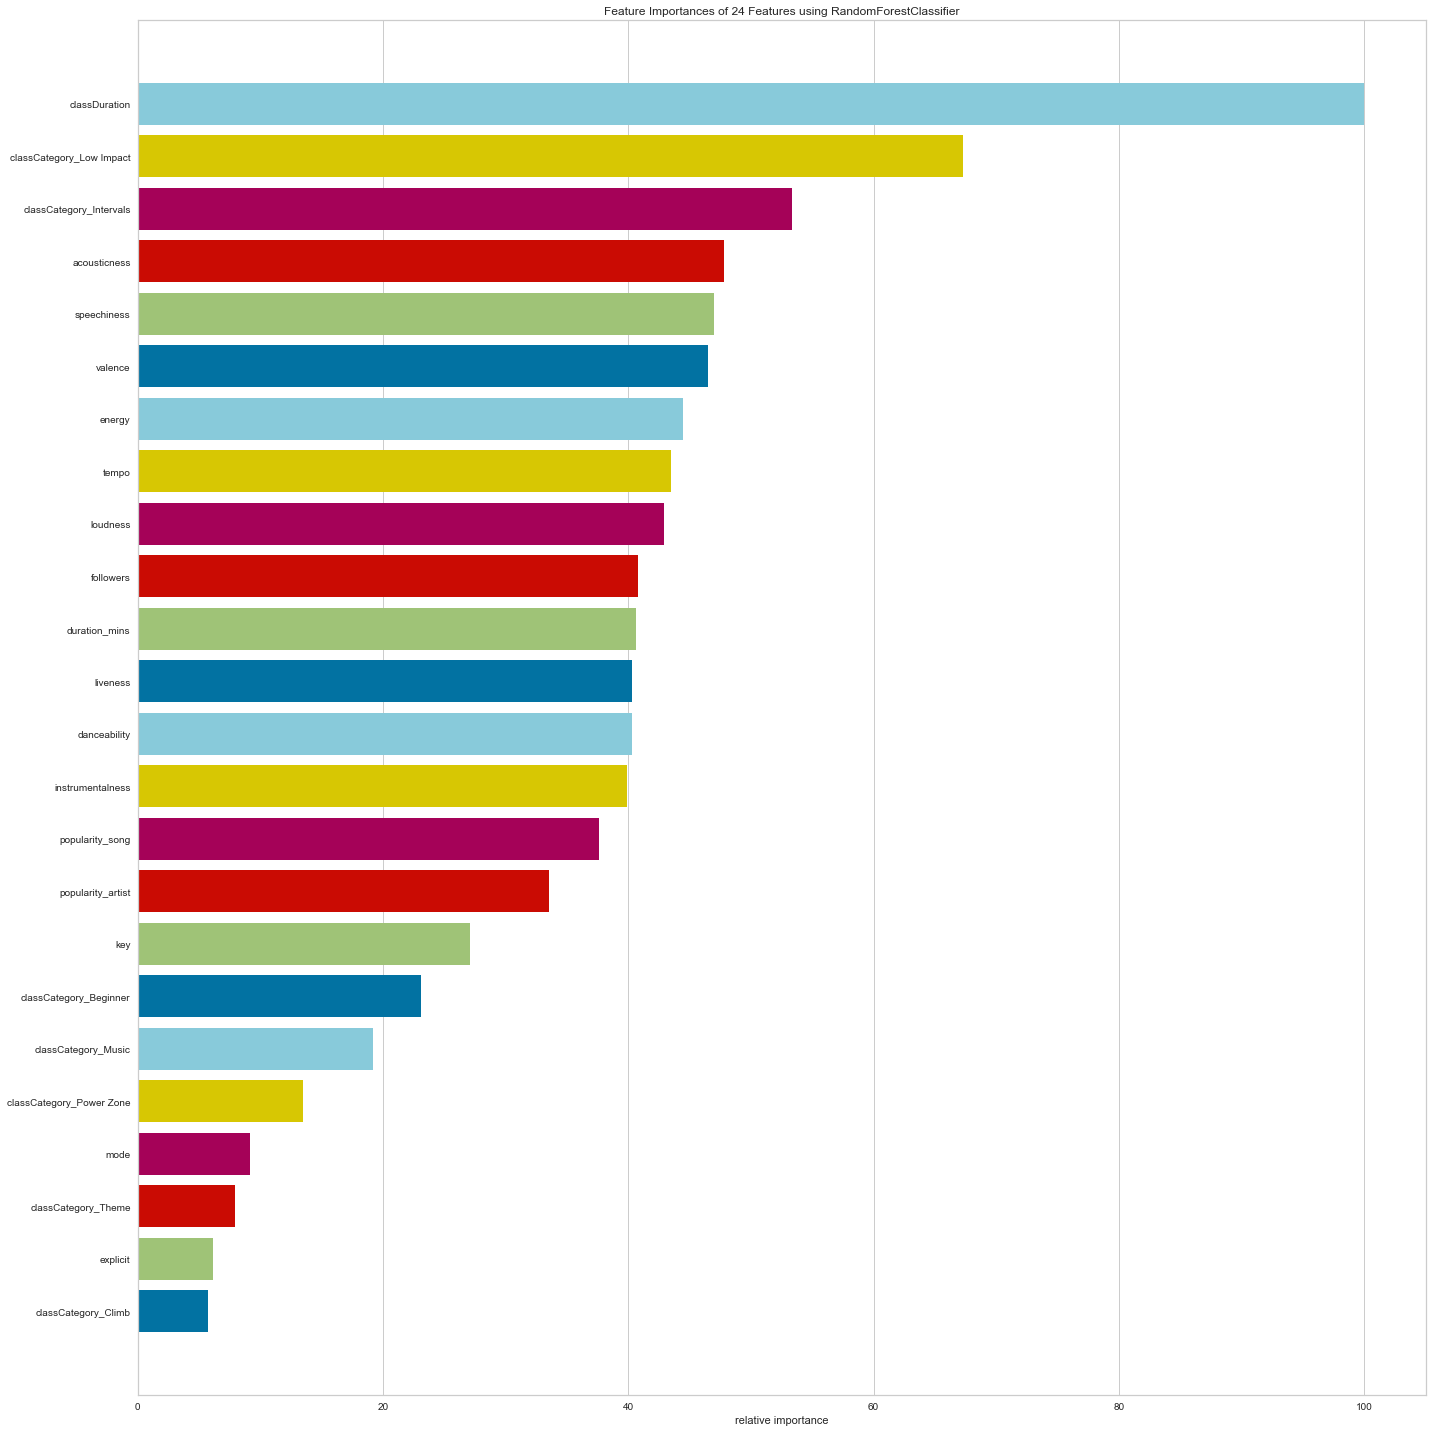

In [192]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf8)
viz.fit(X, y)
viz.show()

### DV9 - Revisit Class Difficult Category - Beginner Rides < 60 mins, Intermediate < 75, Advanced is only difficulty with 75-90 min rides
Class Duration is always most influential, why?

In [193]:
df.groupby(by=['classDifficulty_cat','classDuration'])['classId'].count()

# Relabel:
# - Beginner and classDuration >= 60 = Intermediate
# - Intermediate and classDuration >= 75 = Advanced

classDifficulty_cat  classDuration
Advanced             10                  8
                     15                 34
                     20                184
                     30                651
                     45                832
                     60                 66
Beginner             10                189
                     15                171
                     20                788
                     30                388
                     45                160
                     60                 35
                     75                  1
Intermediate         10                 55
                     15                113
                     20                777
                     30               1711
                     45                748
                     60                 60
                     75                  5
                     90                  7
Name: classId, dtype: int64

In [194]:
for row in df.index:
    if (df['classDifficulty_cat'][row] == 'Beginner') and (df['classDuration'][row] >= 60):
        df['classDifficulty_cat'][row] = 'Intermediate'
    if (df['classDifficulty_cat'][row] == 'Intermediate') and (df['classDuration'][row] >= 75):
        df['classDifficulty_cat'][row] = 'Advanced'
    else:
        continue

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [195]:
df.groupby(by=['classDifficulty_cat','classDuration'])['classId'].count()

classDifficulty_cat  classDuration
Advanced             10                  8
                     15                 34
                     20                184
                     30                651
                     45                832
                     60                 66
                     75                  6
                     90                  7
Beginner             10                189
                     15                171
                     20                788
                     30                388
                     45                160
Intermediate         10                 55
                     15                113
                     20                777
                     30               1711
                     45                748
                     60                 95
Name: classId, dtype: int64

In [196]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation', 'time_signature', 'instructorName'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [197]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory']

#### Numeric Treatment - Scale

In [198]:
# Copy df for manipulation
scaled_features = df.copy()

In [199]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [200]:
# Copy df for manipulation
ohe_features = df.copy()

In [201]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme
0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0


In [202]:
ohe_features = pd.get_dummies(ohe_features)

In [203]:
# Drop Other categories and reset index
ohe_features = ohe_features.drop(columns=['classCategory_Other']).reset_index(drop=True)

#### Combine

In [204]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [205]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Theme', 'classDifficulty_cat'], dtype='object')

In [206]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Theme,classDifficulty_cat
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,Beginner
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,Intermediate
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,Intermediate
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,Intermediate
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,Beginner


#### Model 17 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [207]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [208]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [209]:
# Instantiate
dt9 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt9.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Advanced       0.52      0.50      0.51       464
    Beginner       0.65      0.66      0.65       414
Intermediate       0.63      0.63      0.63       868

    accuracy                           0.61      1746
   macro avg       0.60      0.60      0.60      1746
weighted avg       0.60      0.61      0.60      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.6053837342497136
F1 Score: 0.6053837342497136
F1 Score Mean Cross Val 3-Fold: 0.6095121500255462


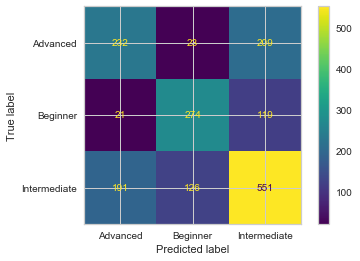

In [210]:
# Try micro 
eval_model(dt9, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

In [211]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

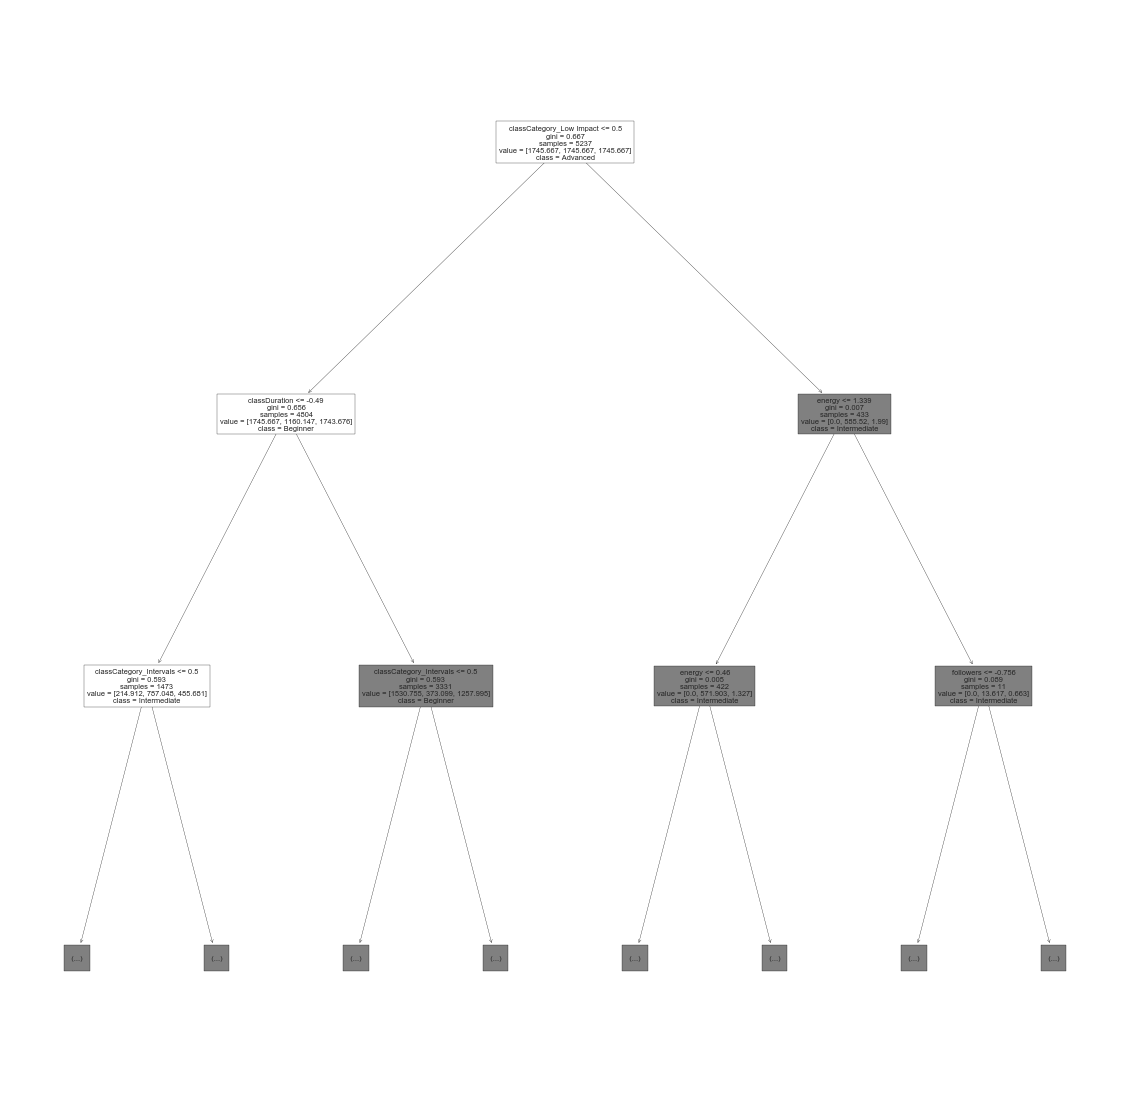

In [212]:
plt.figure(figsize=(20,20))
plot_tree(dt9, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


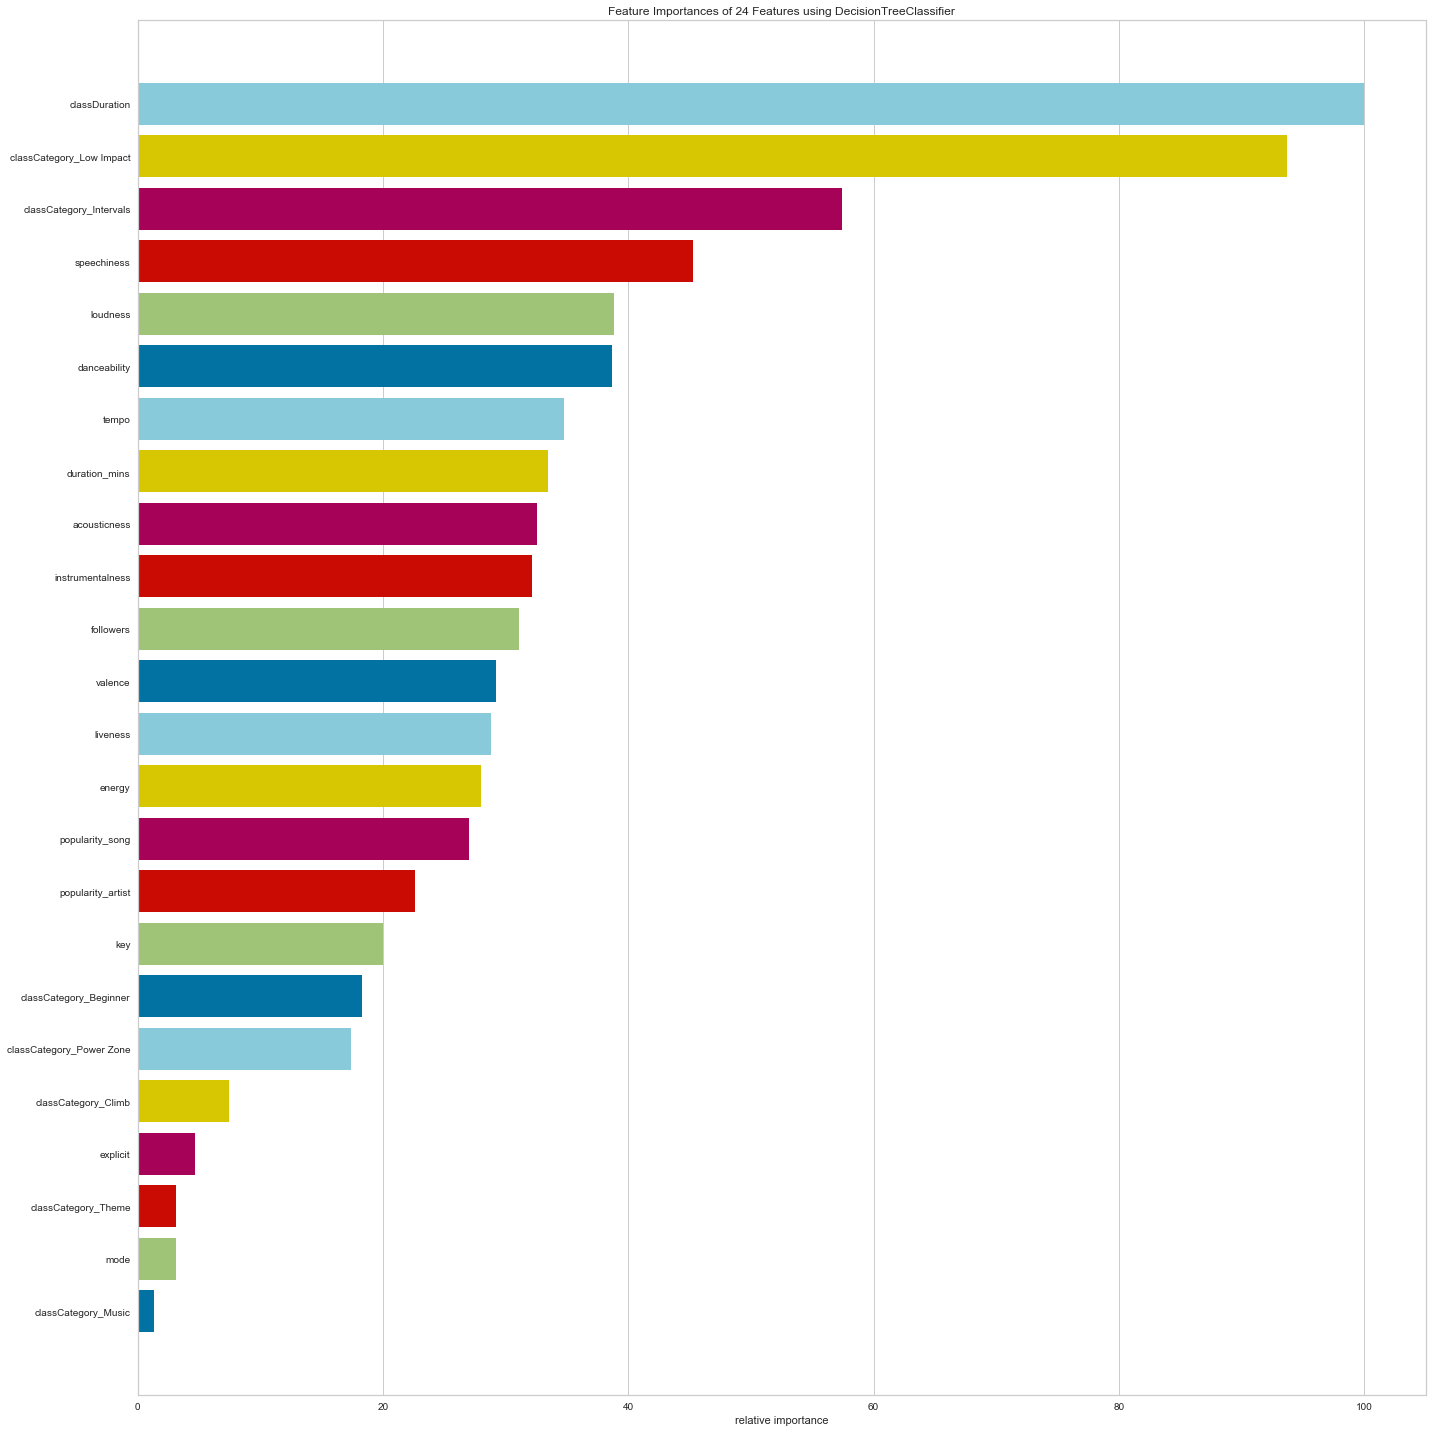

In [213]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt9)
viz.fit(X, y)
viz.show()

#### Model 18- RF with Balanced Class Weight 

Class weight = 'balanced' to account for 25-50-25 split of Target

In [214]:
# Instantiate
rf9 = RandomForestClassifier(class_weight='balanced')

# Fit
rf9.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Advanced       0.67      0.43      0.53       464
    Beginner       0.79      0.60      0.68       414
Intermediate       0.63      0.82      0.71       868

    accuracy                           0.66      1746
   macro avg       0.70      0.62      0.64      1746
weighted avg       0.68      0.66      0.65      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.6626575028636884
F1 Score: 0.6626575028636884
F1 Score Mean Cross Val 3-Fold: 0.6688920835288957


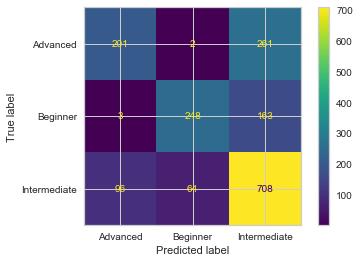

In [215]:
# Try micro 
eval_model(rf9, X_train, X_test, y_train, y_test, ['Advanced', 'Beginner', 'Intermediate'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


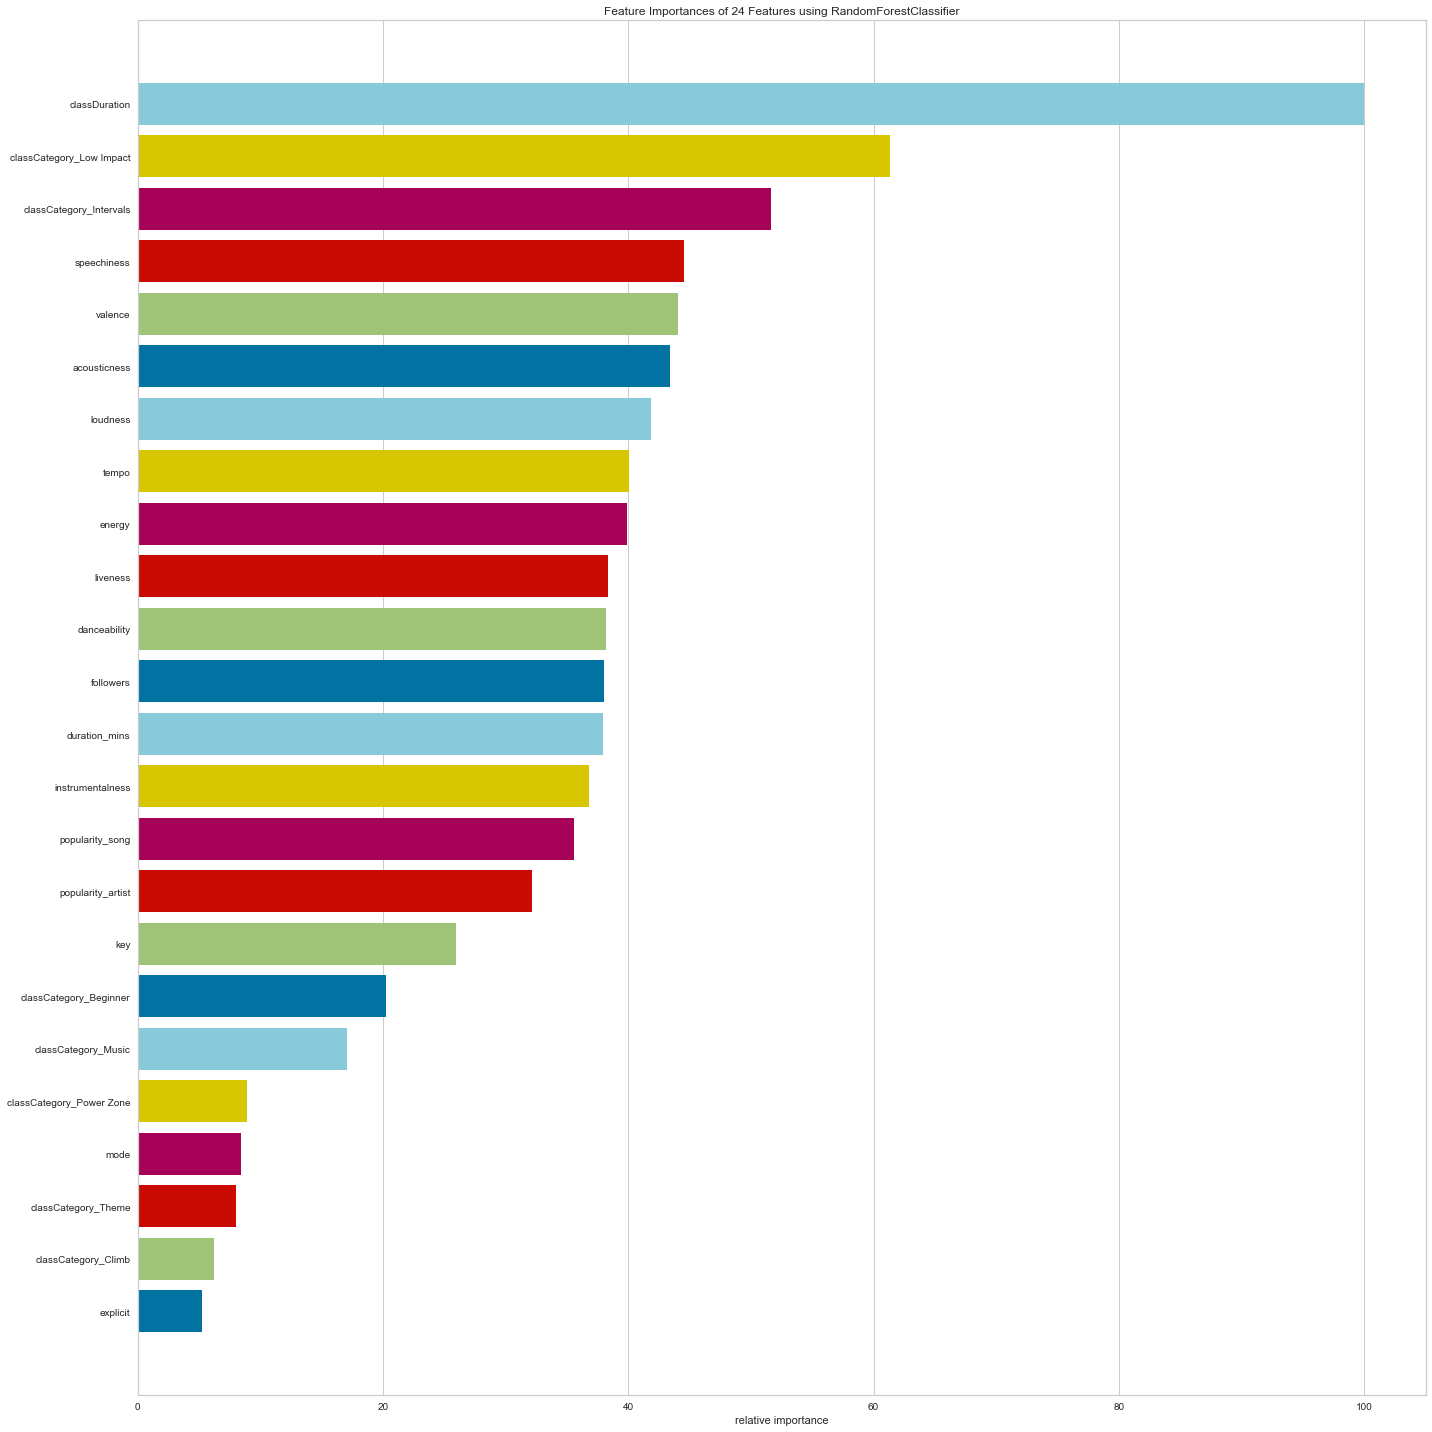

In [216]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf9)
viz.fit(X, y)
viz.show()